# 0. Setup

In [1]:
# pip install --user GitPython
# pip install --user rdkit

In [2]:
# Verify we're in the correct working directory
import os
import git 
from pathlib import Path

def get_project_root():
    return Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

root = get_project_root()

os.chdir(root)
os.getcwd()

'/Users/seraphinashi/Desktop/DataFusion/DrugResponse_Omics_Molecules'

In [3]:
plot_folder = "images/GDSC/"

## import packages, models, trainers

In [4]:
import argparse
import logging
import sys
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

print('pytorch version:', torch.__version__)
print('orig num threads:', torch.get_num_threads())

/Users/seraphinashi/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


pytorch version: 1.13.1
orig num threads: 4


In [5]:
from models import *
from trainers import *
from losses import *
from utils import *
# from cpd_smiles_embed import *

In [6]:
import random
seed=42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Prepare dataset

## Load 

In [7]:
data_folder = "data/GDSC"
c_data = pd.read_csv(os.path.join(data_folder, "c_data.csv"), index_col = 0)
c_meta = pd.read_csv(os.path.join(data_folder, "c_meta.csv"), index_col = 0)
# RNAseq_meta['COSMIC_ID'] = RNAseq_meta['COSMIC_ID'].astype(int)

d_data = pd.read_csv(os.path.join(data_folder, "d_data.csv"), index_col = 0)

cdr = pd.read_csv(os.path.join(data_folder, "cdr.csv"), index_col = 0)

In [8]:
cdr.shape

(847, 174)

## Prepare data
Skin cancer

In [9]:
c_types = ["SKCM"] 

c_meta = c_meta[c_meta["cancer_type"].isin(c_types)]
c_data = c_data[c_data.index.isin(c_meta["COSMIC_ID"])]
cdr = cdr[cdr.index.isin(c_meta["COSMIC_ID"])]

In [10]:
cdr.shape

(54, 174)

In [11]:
# 1. prepare c_meta, 
c_meta_id_col_name = 'COSMIC_ID'
c_meta_type_col_name = 'cancer_type'

c_meta = c_meta[[c_meta_id_col_name, c_meta_type_col_name]]
c_meta = c_meta.rename(columns = {c_meta_id_col_name:'C_ID', c_meta_type_col_name:'C_type'})
c_meta = c_meta[~c_meta['C_ID'].isnull()]

c_meta, meta_map = get_CCL_meta_codes(c_data.index.values, c_meta)
c_meta.index = c_meta.index.astype(str)

print(f"Cancer type coding map: ")
print(meta_map)

Cancer type coding map: 
  C_type  code  count
0   SKCM     0     54


In [12]:
column_counts = c_meta['code'].value_counts()
print(column_counts)

code
0    54
Name: count, dtype: int64


In [13]:
# 2. prepare c_data
## make sure: 
##   1. the index (row names) is cancer cell line names
c_data.index = c_data.index.astype(str)
c_data.shape

(54, 5703)

In [14]:
# 3. prepare d_data
## make sure: 
##   1. the index (row names) is drug names
# cpd_smiles = cpd_smiles[['drug_id', 'smiles']]
# cpd_smiles = cpd_smiles.set_index('drug_id')

# d_data = smiles_to_AtonBondDescriptor_PCAembedings(cpd_smiles)
d_data.index = d_data.index.astype(str)

d_data.shape

(174, 75)

In [15]:
# 4. prepare cdr
## make sure: 
##   1. the index (row names) is cancer cell line names
##   2. the columns (column names) is drug names
cdr.index = cdr.index.astype("str")

common_drugs = list(set(cdr.columns).intersection(set(d_data.index)))
cdr = cdr[common_drugs]
d_data = d_data.loc[common_drugs]

common_cancers = list(set(cdr.index).intersection(set(c_data.index)))
cdr = cdr.loc[common_cancers]
c_data = c_data.loc[common_cancers]
c_meta = c_meta.loc[common_cancers]

print(f'cdr shape: {cdr.shape}')
print(f'c_data shape: {c_data.shape}')
print(f'c_meta shape: {c_meta.shape}')
print(f'd_data shape: {d_data.shape}')

cdr shape: (54, 174)
c_data shape: (54, 5703)
c_meta shape: (54, 2)
d_data shape: (174, 75)


In [16]:
c_meta.head()

code  k0
753545      0   1
906792      0   1
1299078     0   1
1298160     0   1
906830      0   1

# 2. Hyperparameters

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
print(device)

cpu


In [18]:
class Train_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    valid_size = 0.2 #@param {type: "float"}

    n_epochs = 100 #@param {type: "integer"}
    batch_size = 50 #@param {type: "integer"}
    lr = 0.01 #@param {type: "float"}
    
    C_VAE_loss_weight = 0.5 #@param {type: "float"}
    C_recon_loss_weight = 0.1 #@param {type: "float"}
    C_kld_weight = 0.5 #@param {type: "float"}
    C_cluster_distance_weight = 150 #@param {type: "float"}
    C_update_ratio_weight = 10 #@param {type: "float"}"}
    
    D_VAE_loss_weight = 1 #@param {type: "float"}
    D_recon_loss_weight = 1 #@param {type: "float"}
    D_kld_weight = 0.5 #@param {type: "float"}
    D_cluster_distance_weight = 100 #@param {type: "float"}
    D_update_ratio_weight = 10 #@param {type: "float"}
    
    predict_loss_weight = 4000 #@param {type: "float"}
    
    cVAE_save_path = 'data/model_fits/GDSC_skin_c_vae' #@param
    dVAE_save_path = 'data/model_fits/GDSC_skin_d_vae_skin' #@param
    
    c_p_save_path = 'data/model_fits/GDSC_skin_c_vae_predictor' #@param
    d_p_save_path = 'data/model_fits/GDSC_skin_d_vae_predictor' #@param



class CDPModel_sub_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    # c_VAE
    c_input_dim = 0 #@param {type: "integer"}
    c_h_dims = [1024, 512, 256] #@param {type: "vactor"}
    c_latent_dim = 32 #@param {type: "integer"}

    # d_VAE
    d_input_dim = 0 #@param {type: "integer"}
    d_h_dims = [64]  #@param {type: "vactor"}
    d_latent_dim = 32 #@param {type: "integer"}

    # predictor
    p_sec_dim = 16 #@param {type: "integer"}
    p_h_dims = [p_sec_dim*2, 16]  #@param {type: "vactor"}
    
    # all
    drop_out = 0  #@param {type: "float"}
    
    # sensitive threshold
    sens_cutoff = 0.5
    


In [19]:
train_args = Train_Args()

K = len(c_meta[c_meta['code'] != -1]['code'].unique())

CDPmodel_args = CDPModel_sub_Args()
CDPmodel_args['c_input_dim'] = c_data.shape[1] 
CDPmodel_args['d_input_dim'] = d_data.shape[1]

if CDPmodel_args['c_input_dim'] <= 0:
  warnings.warn(
      '''\nCancer Cell line feature number not specified''')
if CDPmodel_args['d_input_dim'] <= 0:
  warnings.warn(
      '''\nDrug feature number not specified''')

# 3. Train Model

In [20]:
CDPmodel = CDPmodel(K, CDPmodel_args)


In [21]:
n_rounds = 5
fit_returns = CDPmodel.fit(c_data, c_meta, d_data, cdr, train_args, n_rounds=n_rounds, device = device)

=> Initialize C-VAE:
        Best epoc with test loss: epoch 98
        Running time: 32.14674210548401
=> Initialize D-VAE:
        Best epoc with test loss: epoch 73
        Running time: 1.1111679077148438
########################################################
#### 0. k = 0                                     
########################################################
  === 0.1. Training local CDP model 
     -- round 0 -------------
       a. Training D_VAE and Predictor
            Best epoc with test loss: epoch 75
            Running time: 1983.2403519153595
       b. 31.0 sensitive drug(s)
       c. Training C_VAE and Predictor
            Best epoc with test loss: epoch 97
            Running time: 467.4703459739685
       d. 28 cancer cell line(s) in the cluster
     -- round 1 -------------
       a. Training D_VAE and Predictor
            Best epoc with test loss: epoch 8
            Running time: 982.9116299152374
       b. 32.0 sensitive drug(s)
       c. Training C_VAE 

In [22]:
c_meta, c_meta_hist, d_sens_hist, losses_train_hist_list, best_epos_list, C_VAE_init_losses, D_VAE_init_losses, c_latent_list, d_latent_list = fit_returns


In [23]:
best_epos_list

[[[75, 97], [8, 48], [41, 24], [5, 12], [21, 64], None]]

# 4. Results and visualizations

In [24]:
cdr_hat = CDPmodel.predict(c_data, d_data)

In [25]:
cdr_train_hat = cdr_hat

cdr_train_rslt = cdr.copy()
cdr_train_rslt['c_name'] = cdr_train_rslt.index.values
cdr_train_rslt = pd.melt(cdr_train_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_train_rslt = cdr_train_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})

cdr_train_rslt = pd.merge(cdr_train_rslt, cdr_train_hat, on=['c_name', 'd_name'], how='outer')

In [26]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Binary cross entropy
cdr_train_rslt_noNA = cdr_train_rslt.dropna(subset=['cdr_hat', 'cdr'])
binary_cross_entropy_train = log_loss(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print(f"Binary cross entropy: {binary_cross_entropy_train}")


# Area Under the Curve (AUC) for a Receiver Operating Characteristic (ROC) 
roc_auc = roc_auc_score(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print("ROC AUC:", roc_auc)

# confusion_ atrix
cdr_train_rslt_noNA['cdr_hat_bnr'] = (cdr_train_rslt_noNA['cdr_hat'] > 0.5).astype(int)

conf_matrix = confusion_matrix(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat_bnr'])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"\nTrue Positive:  {tp} ({(tp / (tp + fn)) * 100:.2f} %)")
print(f"False Negative: {fn} ({(fn / (fn + tp)) * 100:.2f} %)")

print(f"True Negative:  {tn} ({(tn / (tn + fp)) * 100:.2f} %)")
print(f"False Positive: {fp} ({(fp / (fp + tn)) * 100:.2f} %)")

Binary cross entropy: 2.330050487615336
ROC AUC: 0.6938150153953329

True Positive:  51 (3.61 %)
False Negative: 1362 (96.39 %)
True Negative:  6506 (99.82 %)
False Positive: 12 (0.18 %)


<ipython-input-26-1853eaf8498a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdr_train_rslt_noNA['cdr_hat_bnr'] = (cdr_train_rslt_noNA['cdr_hat'] > 0.5).astype(int)


In [141]:
# output data

cdr_hat.to_csv(os.path.join(data_folder, "skin_v1/GDSC_skin_cdr_hat.csv"), index=True)

c_latent = pd.DataFrame(c_latent_list[0][n_rounds-1])
c_latent.index = c_data.index
c_latent.to_csv(os.path.join(data_folder, "skin_v1/GDSC_skin_c_latent_cluster1.csv"), index=True)

if CDPmodel.K == 2:
    c_latent_1 = pd.DataFrame(c_latent_list[1][n_rounds-1])
    c_latent_1.index = c_data.index
    c_latent_1.to_csv(os.path.join(data_folder, "skin_v1/GDSC_skin_c_latent_cluster2.csv"), index=True)
    
d_latent = pd.DataFrame(d_latent_list[0][n_rounds-1])
d_latent.index = d_data.index
d_latent.to_csv(os.path.join(data_folder, "skin_v1/GDSC_skin_d_latent_cluster1.csv"), index=True)

In [31]:
cdr_train_hat = CDPmodel.predict(c_data, d_data)

cdr_train_rslt = cdr.copy()
cdr_train_rslt['c_name'] = cdr_train_rslt.index.values
cdr_train_rslt = pd.melt(cdr_train_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_train_rslt = cdr_train_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})


cdr_train_rslt = pd.merge(cdr_train_rslt, cdr_train_hat, on=['c_name', 'd_name'], how='outer')

cdr_train_rslt

c_name d_name  cdr   cdr_hat   cdr_all  cluster
0      753545   1830  NaN  0.123349  0.123349        0
1      906792   1830  0.0  0.061319  0.061319        0
2     1299078   1830  0.0         0         0       -1
3     1298160   1830  NaN  0.239475  0.239475        0
4      906830   1830  0.0         0         0       -1
...       ...    ...  ...       ...       ...      ...
9391   906814   1933  0.0  0.605713  0.605713        0
9392  1298144   1933  0.0  0.239475  0.239475        0
9393  1287706   1933  0.0  0.099602  0.099602        0
9394   910853   1933  1.0         0         0       -1
9395  1299080   1933  0.0  0.190372  0.190372        0

[9396 rows x 6 columns]

## Clusters

In [32]:
print('Cancer clustering before:')
print(c_meta_hist.code.value_counts())
print('Cancer clustering after:')
print(c_meta_hist.code_latest.value_counts())

Cancer clustering before:
code
0    54
Name: count, dtype: int64
Cancer clustering after:
code_latest
0     27
-1    27
Name: count, dtype: int64


In [33]:
print('Sensitive to clusters before:')
print(d_sens_hist.sensitive_k.value_counts())
print('Sensitive to clusters after:')
print(d_sens_hist.sensitive_k_latest.value_counts())

Sensitive to clusters before:
sensitive_k
-1    154
0      20
Name: count, dtype: int64
Sensitive to clusters after:
sensitive_k_latest
-1    143
0      31
Name: count, dtype: int64


## Visualizations

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

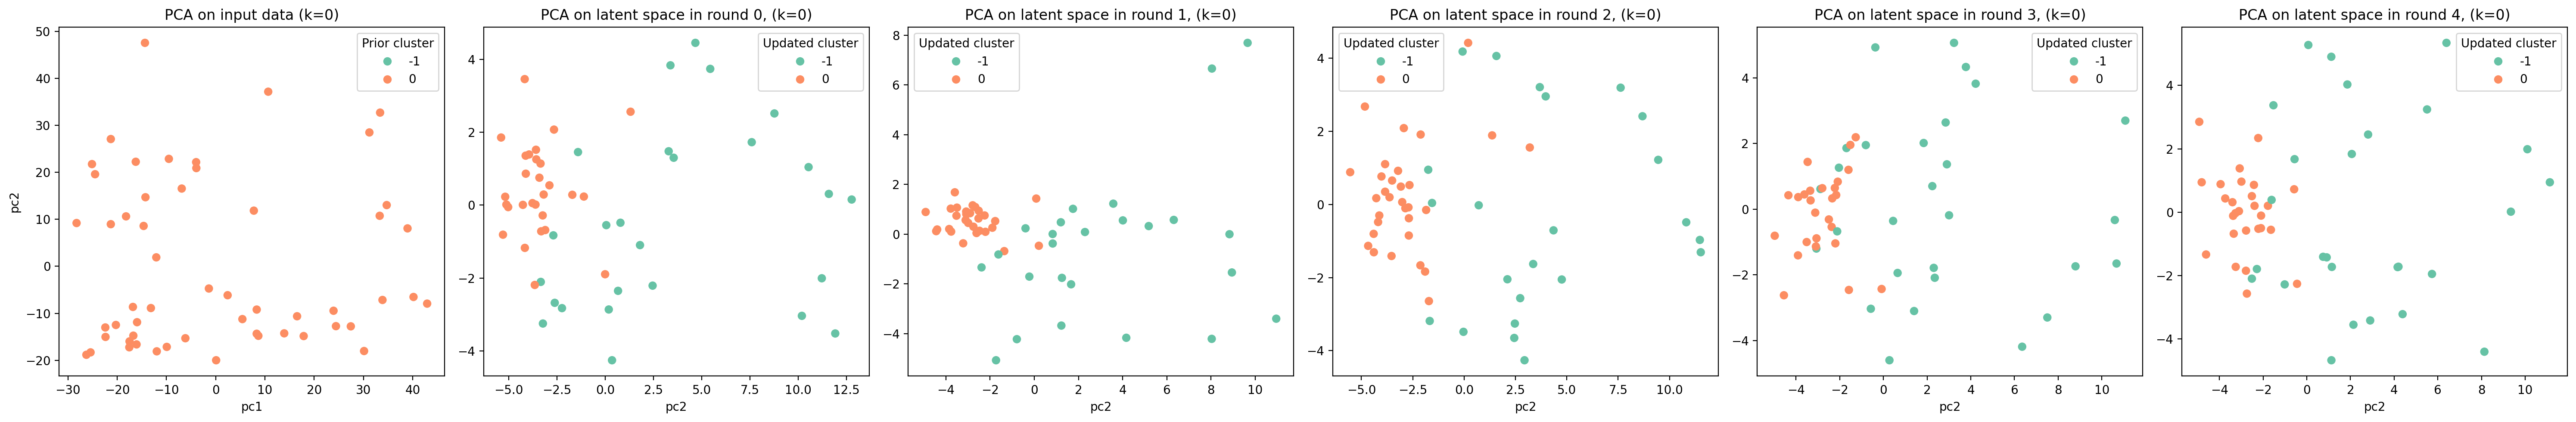

In [35]:
plot_c_PCA_latent(c_data, n_rounds, fit_returns, model=CDPmodel, plots_save_path=f'results/images/GDSC/GDSC_skin_c_latent')

# for k in range(CDPmodel.K):
#    plot_c_PCA_latent(c_data, c_latent_list, c_meta_hist, n_rounds, legend_title='cluster', k=k, 
#                      plot_save_path=f'results/images/GDSC/GDSC_skin_c_latent_k{k}.png')

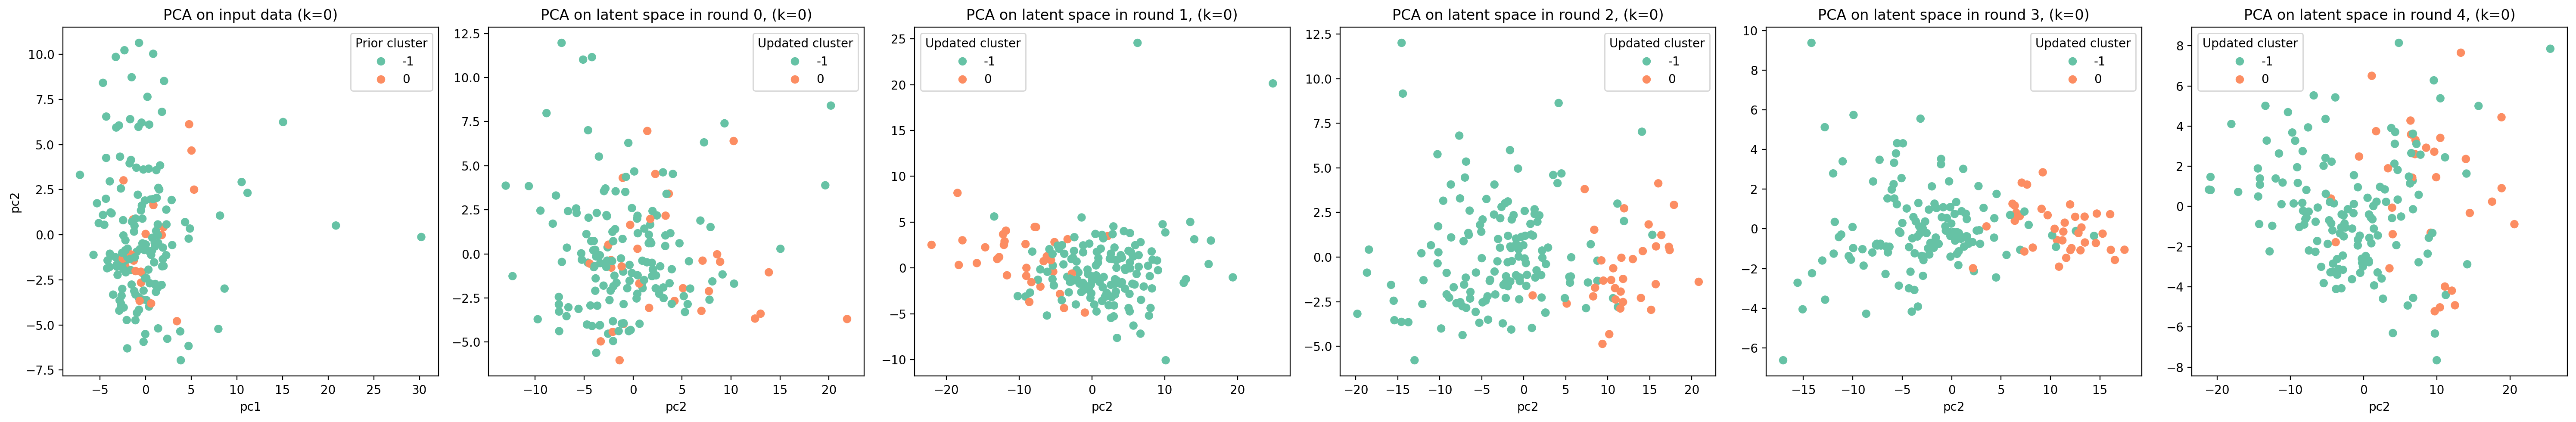

In [36]:
plot_d_PCA_latent(d_data, n_rounds, fit_returns, model=CDPmodel, plots_save_path=f'results/images/GDSC/GDSC_skin_d_latent')

#for k in range(K):
#    plot_d_PCA_latent(d_data, d_latent_list, d_sens_hist, n_rounds, legend_title='cluster', k=k, 
#                      plot_save_path=f'results/images/GDSC/GDSC_skin_d_latent_k{k}.png')

### Losses:

k = 0:
round 0:


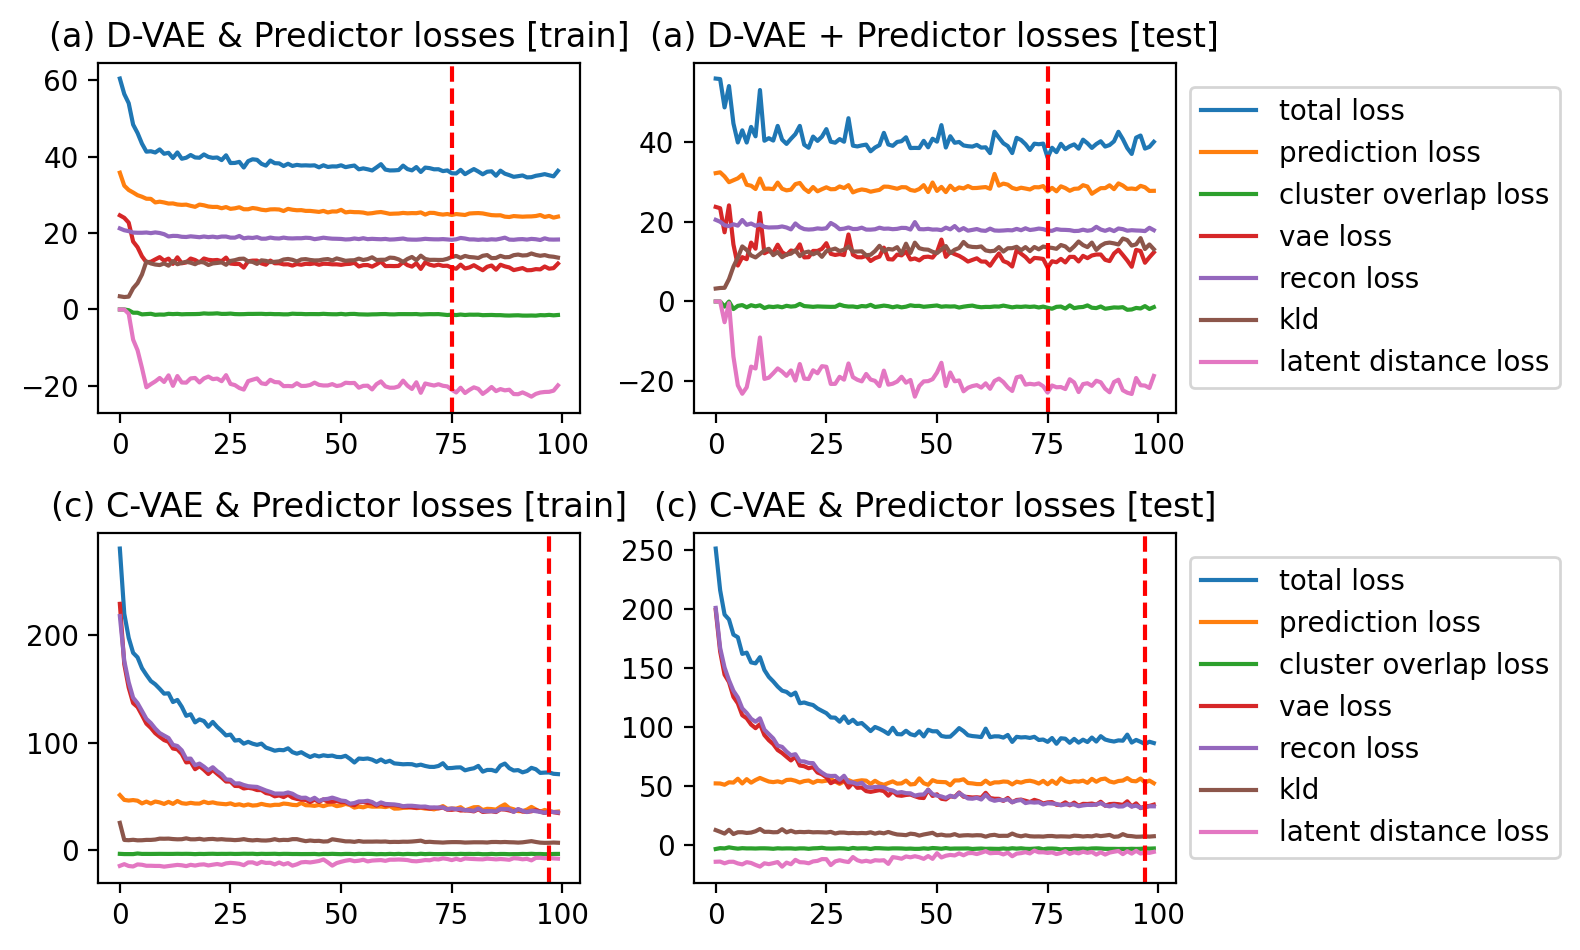

round 1:


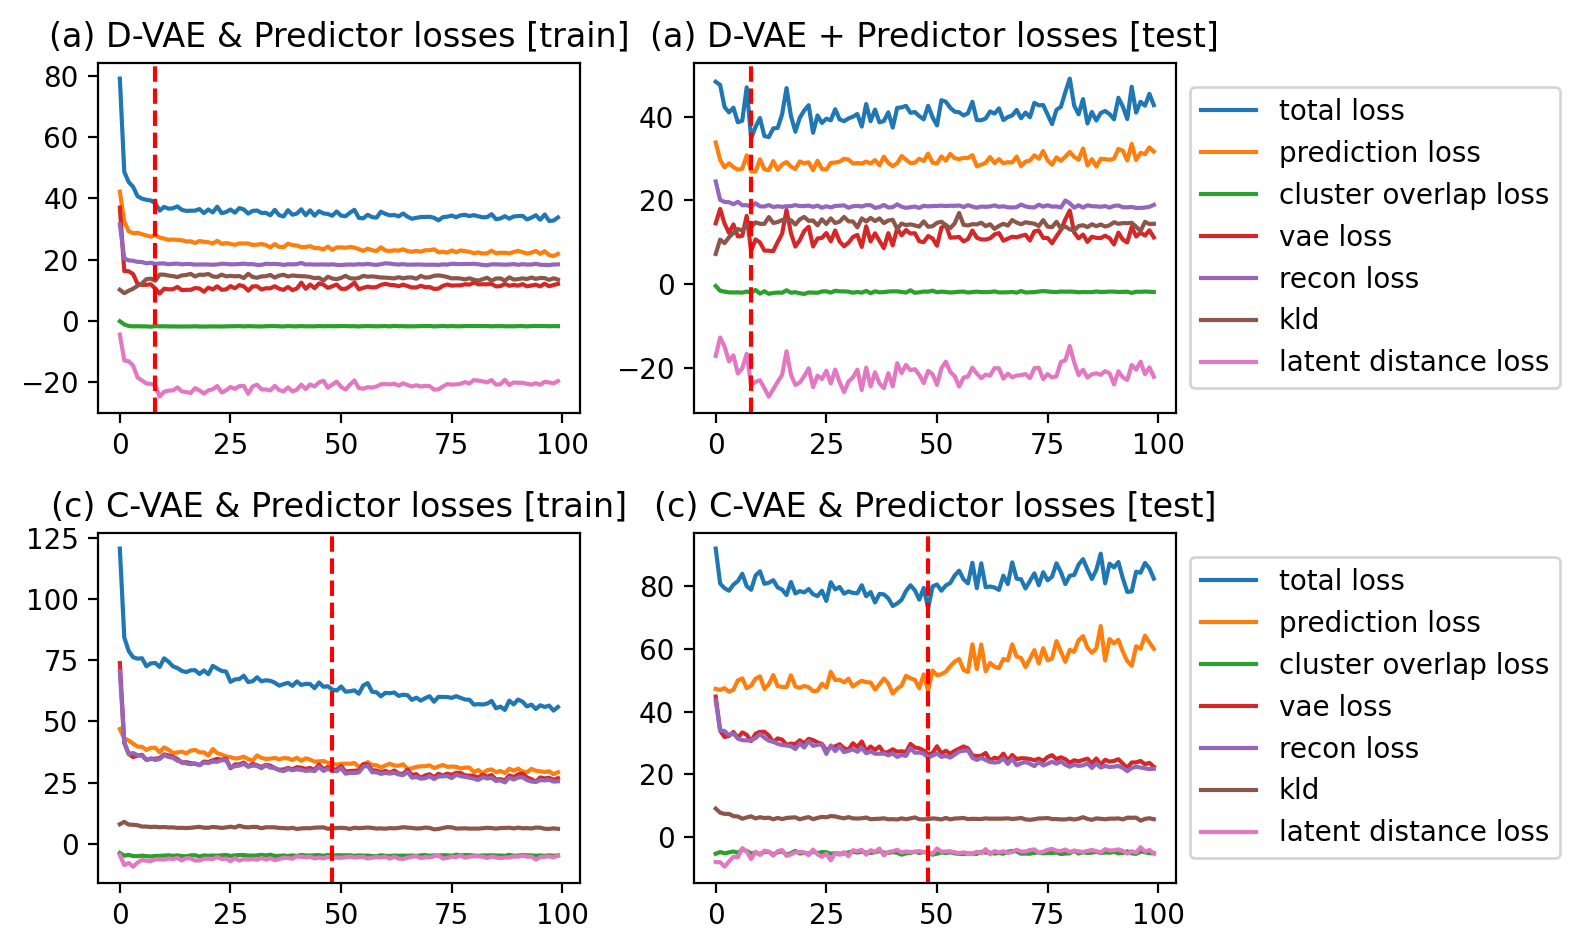

round 2:


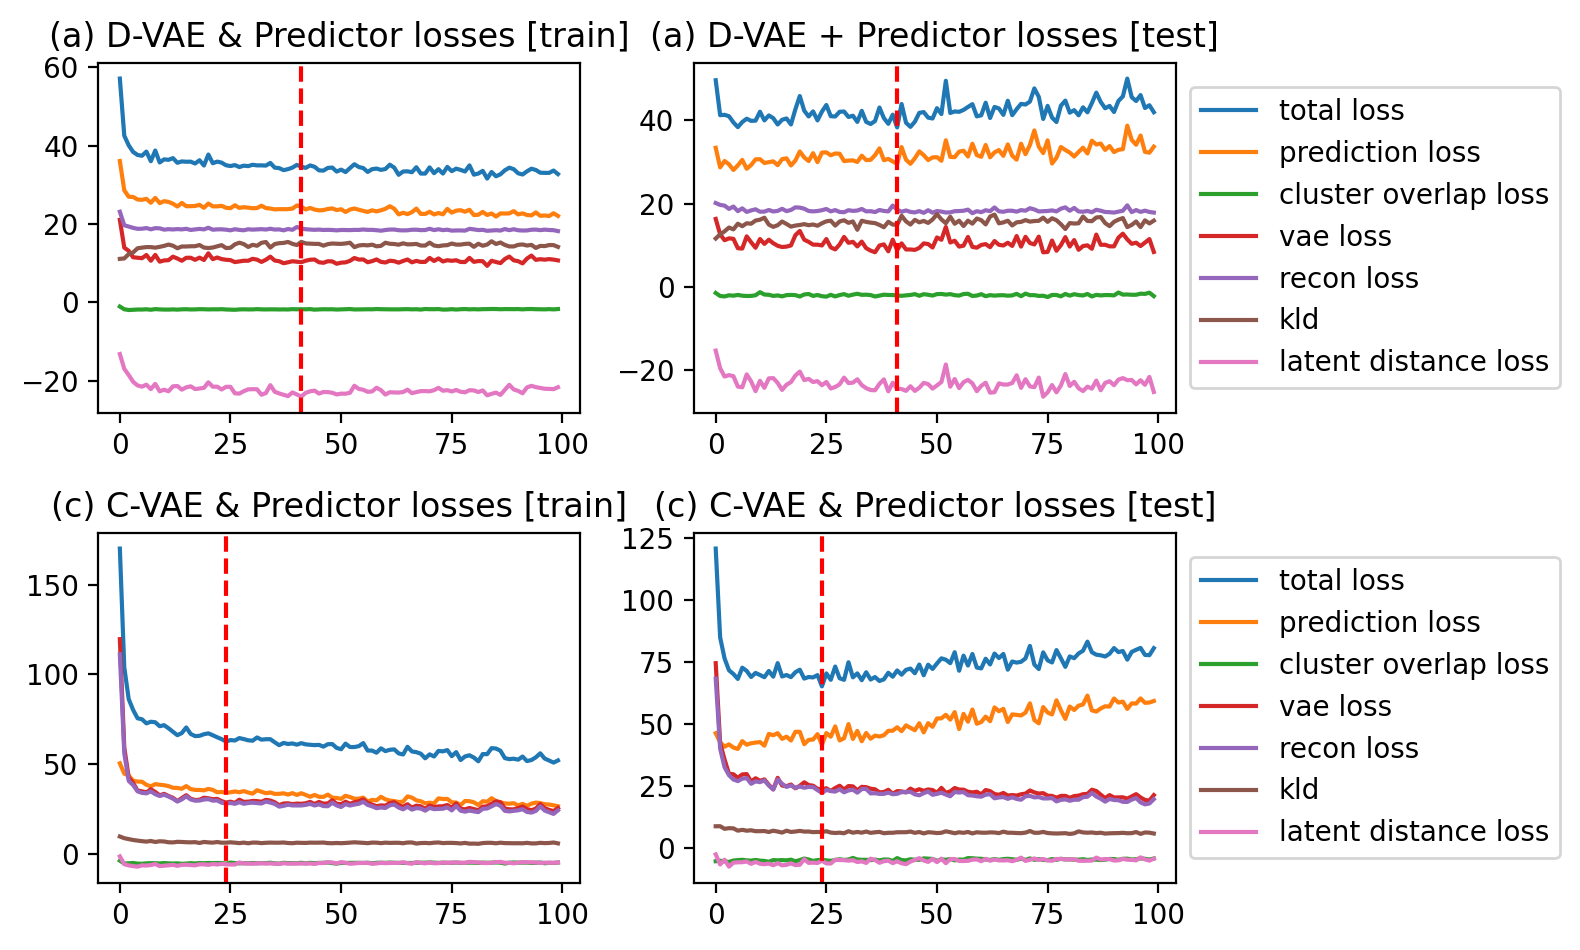

round 3:


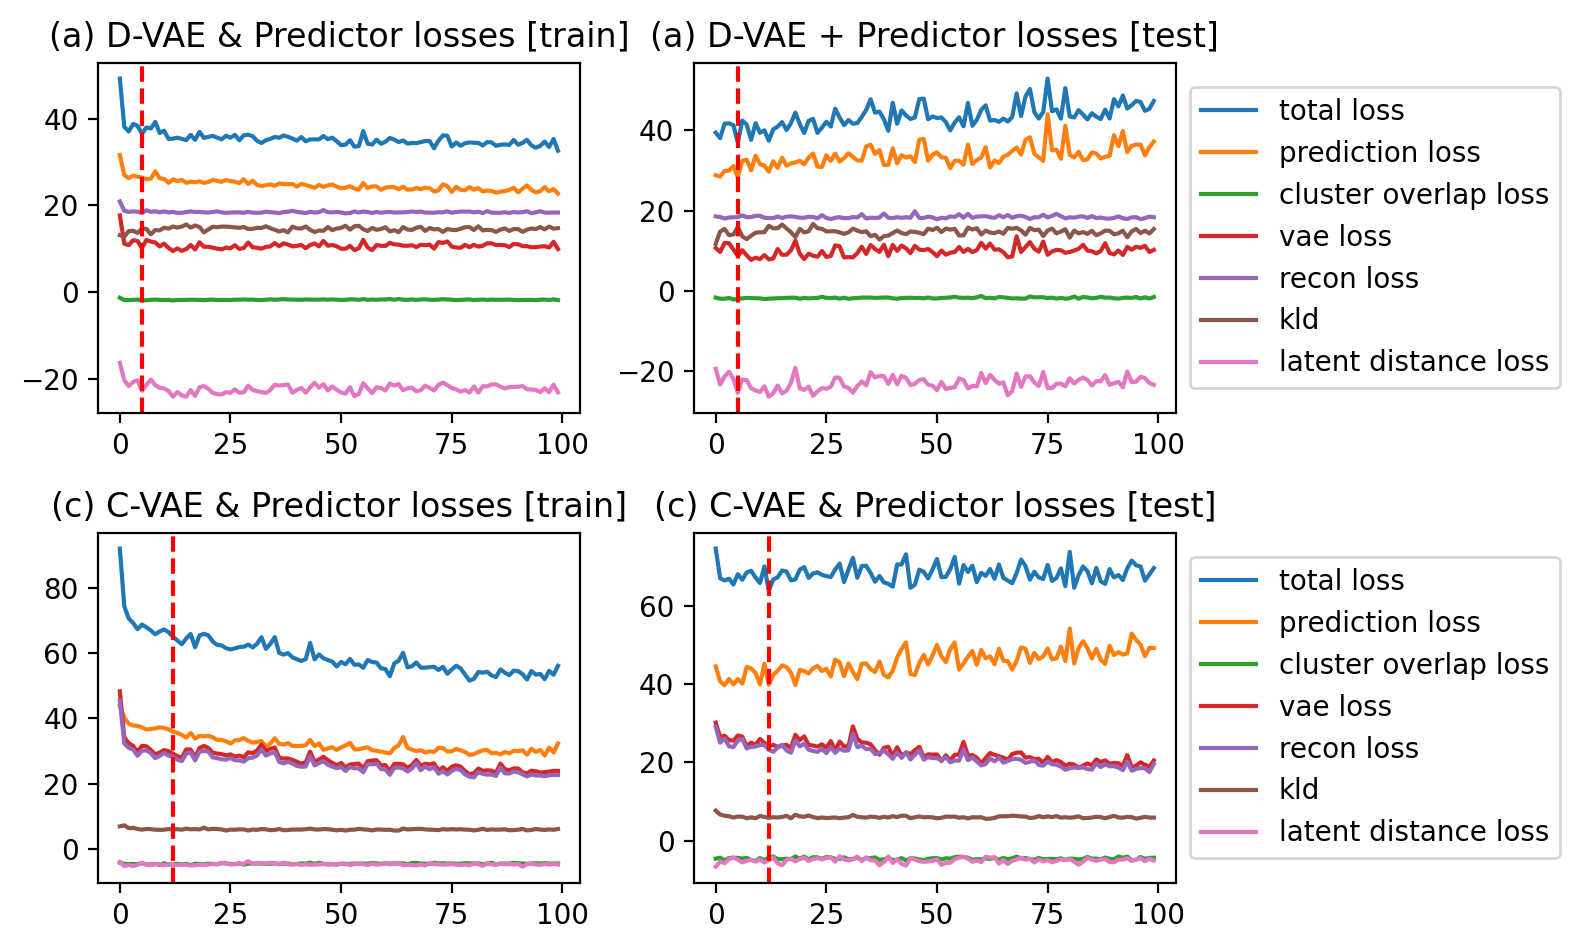

round 4:


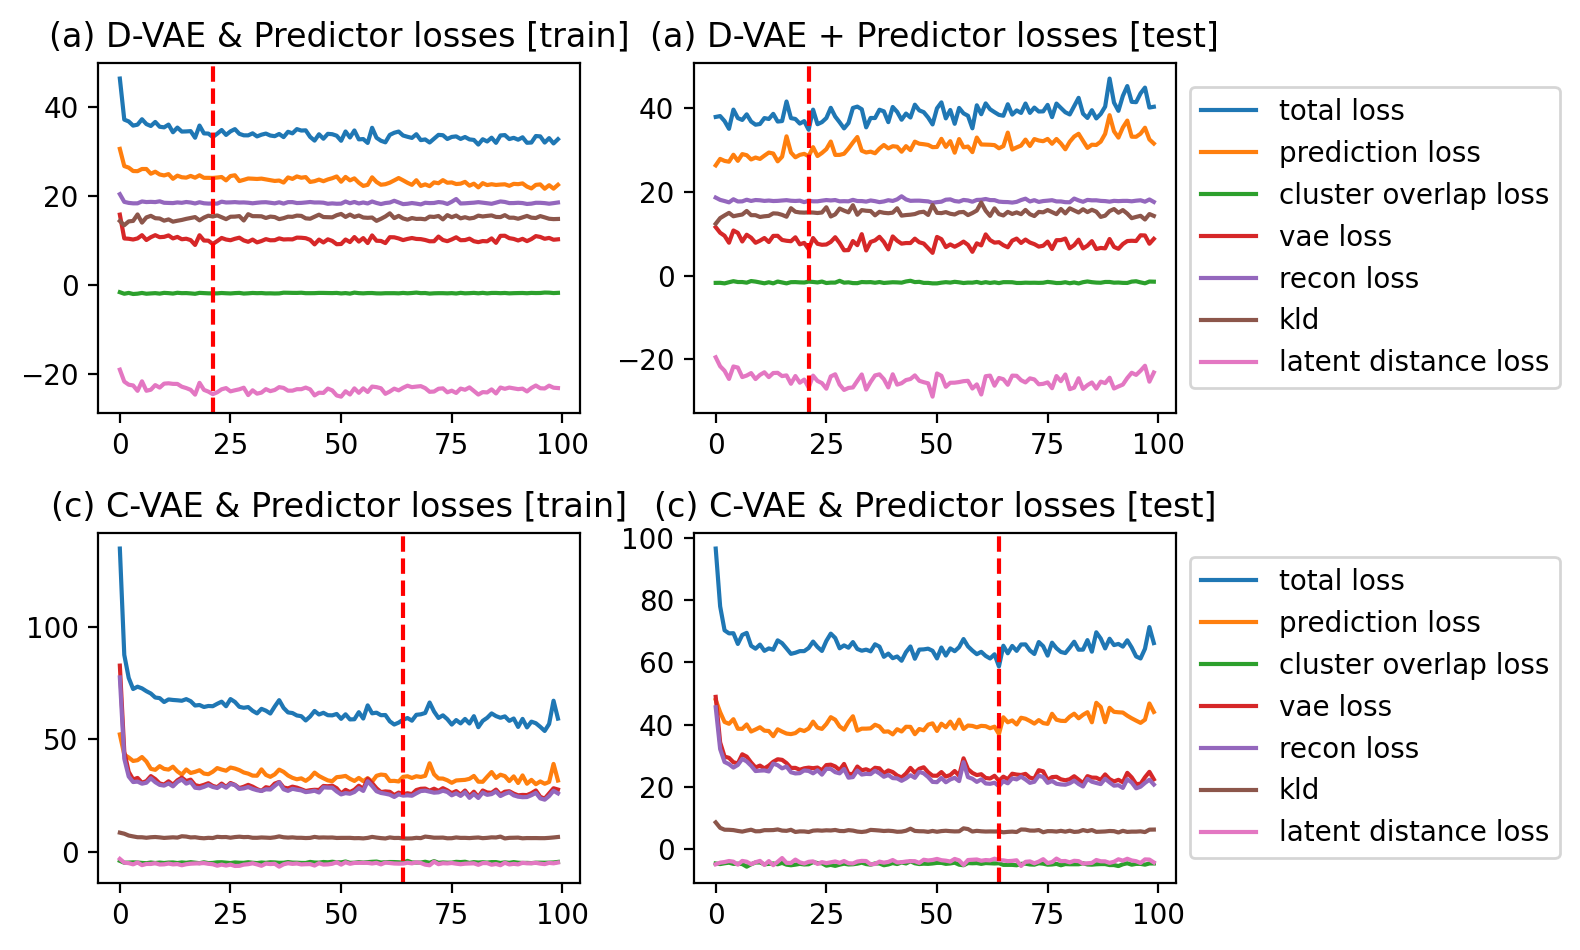

In [37]:
for k in range(CDPmodel.K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_training_losses_train_test_2cols(losses_train_hist_list[k][b], best_epoch_1round = best_epos_list[k][b],
                                              plot_save_path=f'results/images/GDSC/GDSC_skin_losses_b{b}_k{k}.png')
        

In [38]:
def plot_pre_training_losses_train_test_2cols(losses_train_hist_list_1round, best_epoch_1round = [], plot_save_path=''):
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    fig.suptitle('')
    
    losses = losses_train_hist_list_1round[0]
    axs[0,0].plot(np.array(losses["epoch"]), 
                  np.array(losses["prediction_loss_train"]), 
                  label = "prediction loss");
    if best_epoch_1round != []:
            axs[0,0].axvline(x=best_epoch_1round[0], color='r', linestyle='--')
    axs[0,0].set_title('(c) D-VAE & Predictor losses [train]')

    
    
    axs[0,1].plot(np.array(losses["epoch"]), 
                  np.array(losses["prediction_loss_test"]), 
                  label = "prediction loss");
    if best_epoch_1round != []:
        axs[0,1].axvline(x=best_epoch_1round[0], color='r', linestyle='--')
    axs[0,1].set_title('(c) D-VAE & Predictor losses [test]')
    axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    

    
    losses = losses_train_hist_list_1round[1]
    axs[1,0].plot(np.array(losses["epoch"]), 
                  np.array(losses["prediction_loss_train"]), 
                  label = "prediction loss");
    if best_epoch_1round != []:
            axs[1,0].axvline(x=best_epoch_1round[1], color='r', linestyle='--')
    axs[1,0].set_title('(g) C-VAE & Predictor losses [train]')
    
    
    axs[1,1].plot(np.array(losses["epoch"]), 
                  np.array(losses["prediction_loss_test"]), 
                  label = "prediction loss");
    if best_epoch_1round != []:
        axs[1,1].axvline(x=best_epoch_1round[1], color='r', linestyle='--')
    axs[1,1].set_title('(g) C-VAE & Predictor losses [test]')
    axs[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()

    if plot_save_path != '':
        plt.savefig(plot_save_path, dpi=1200)

    plt.show()








k = 0:
round 0:


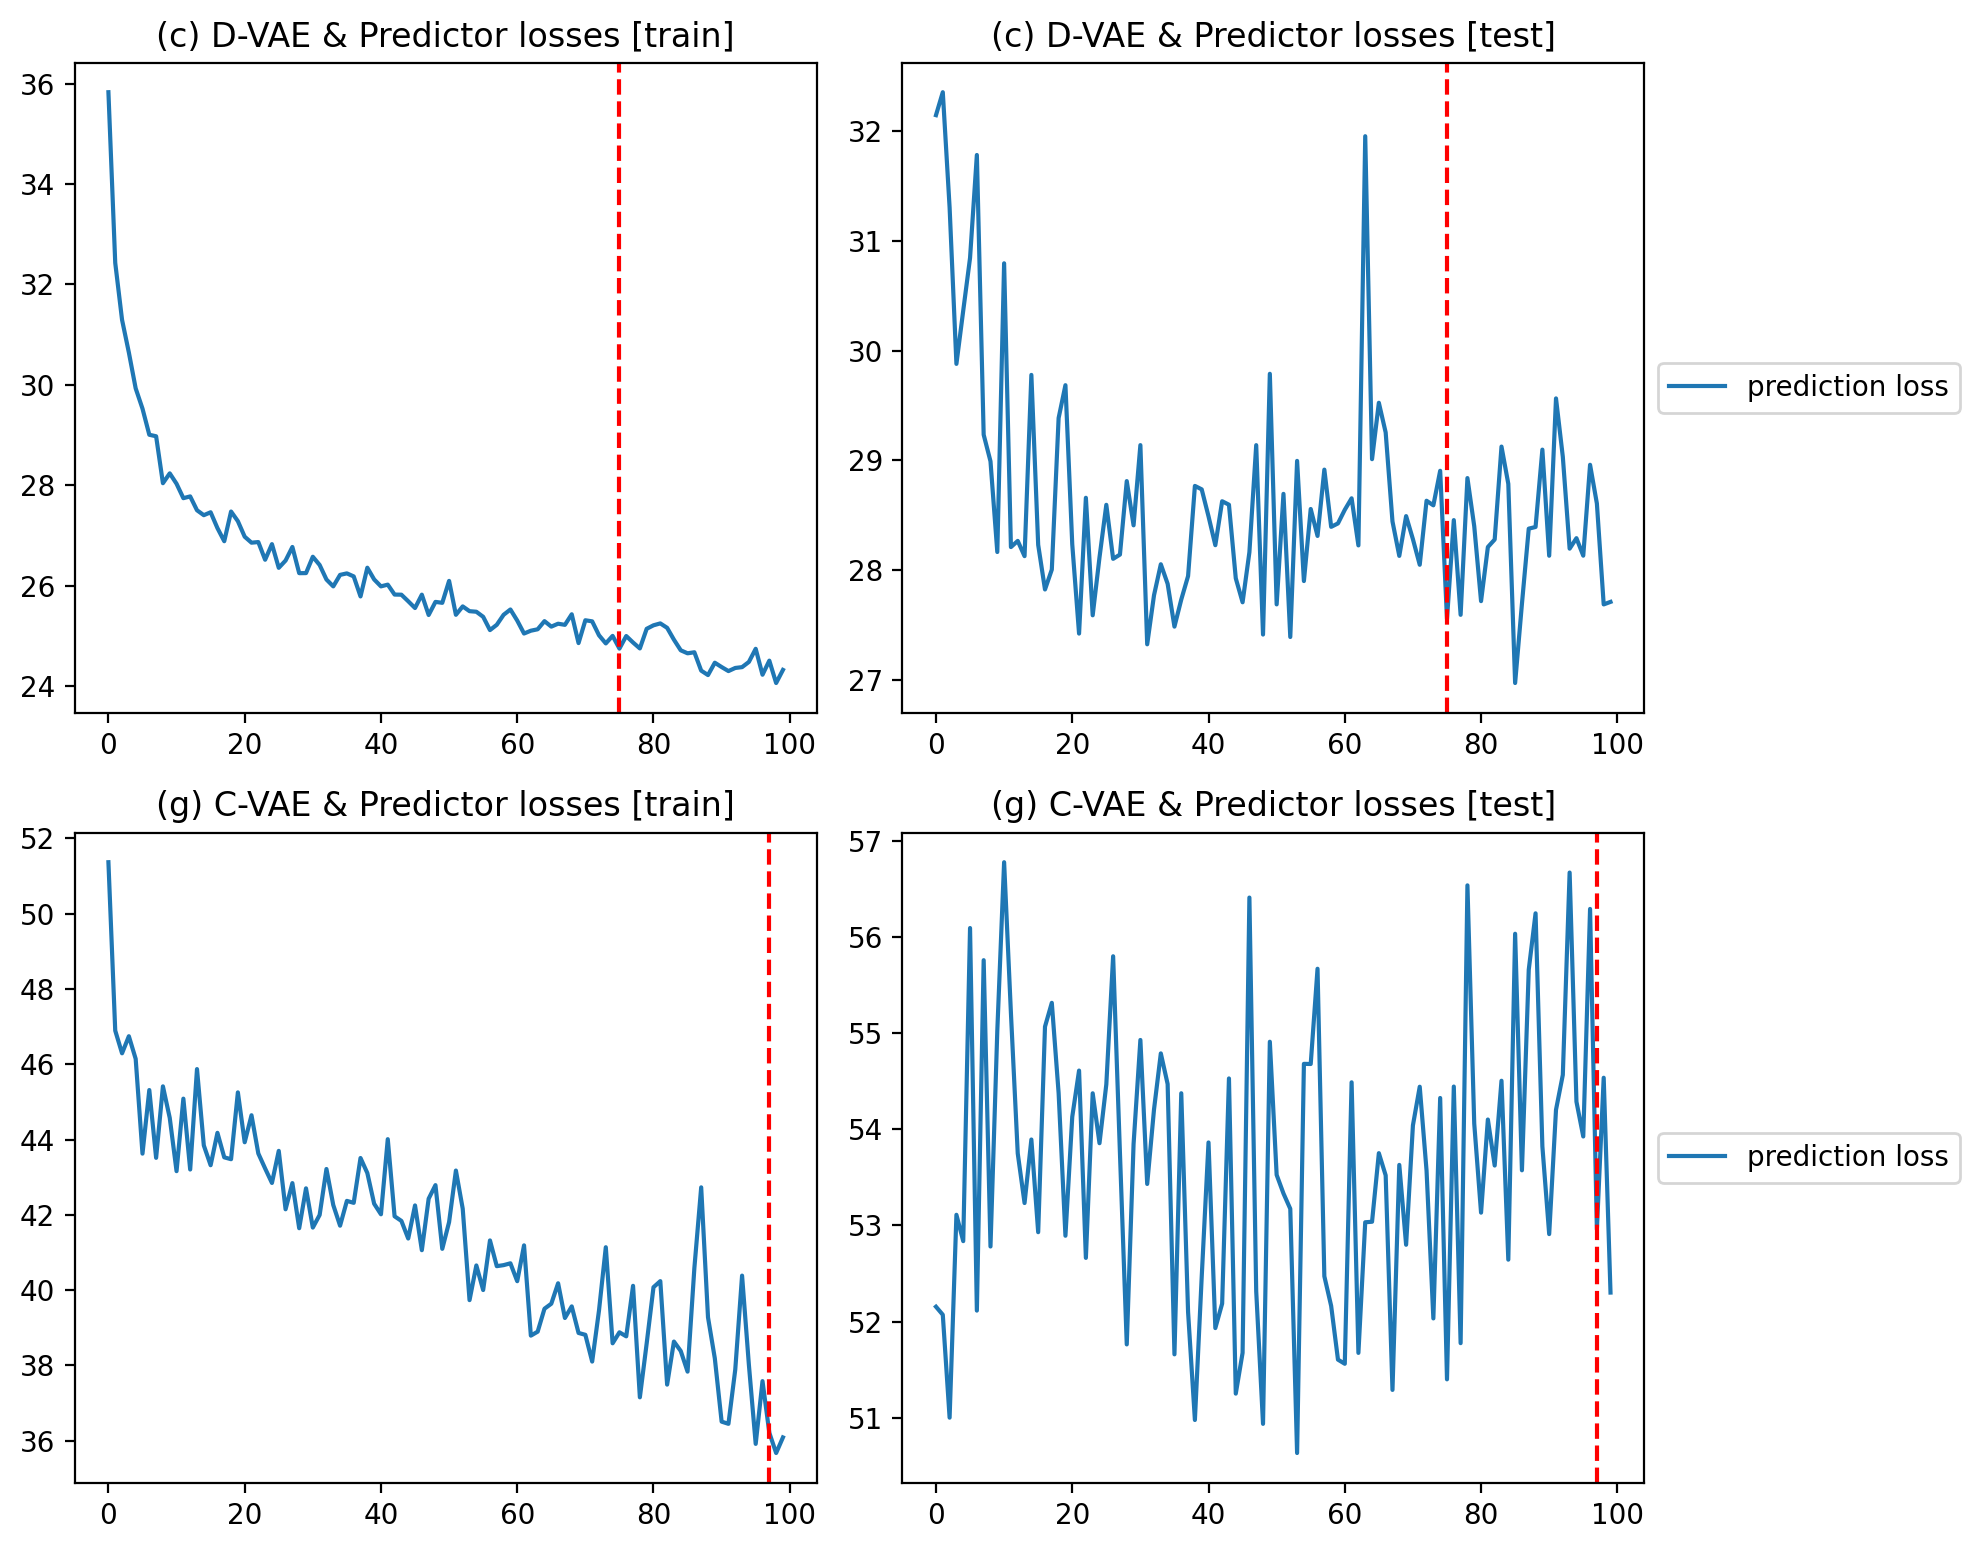

round 1:


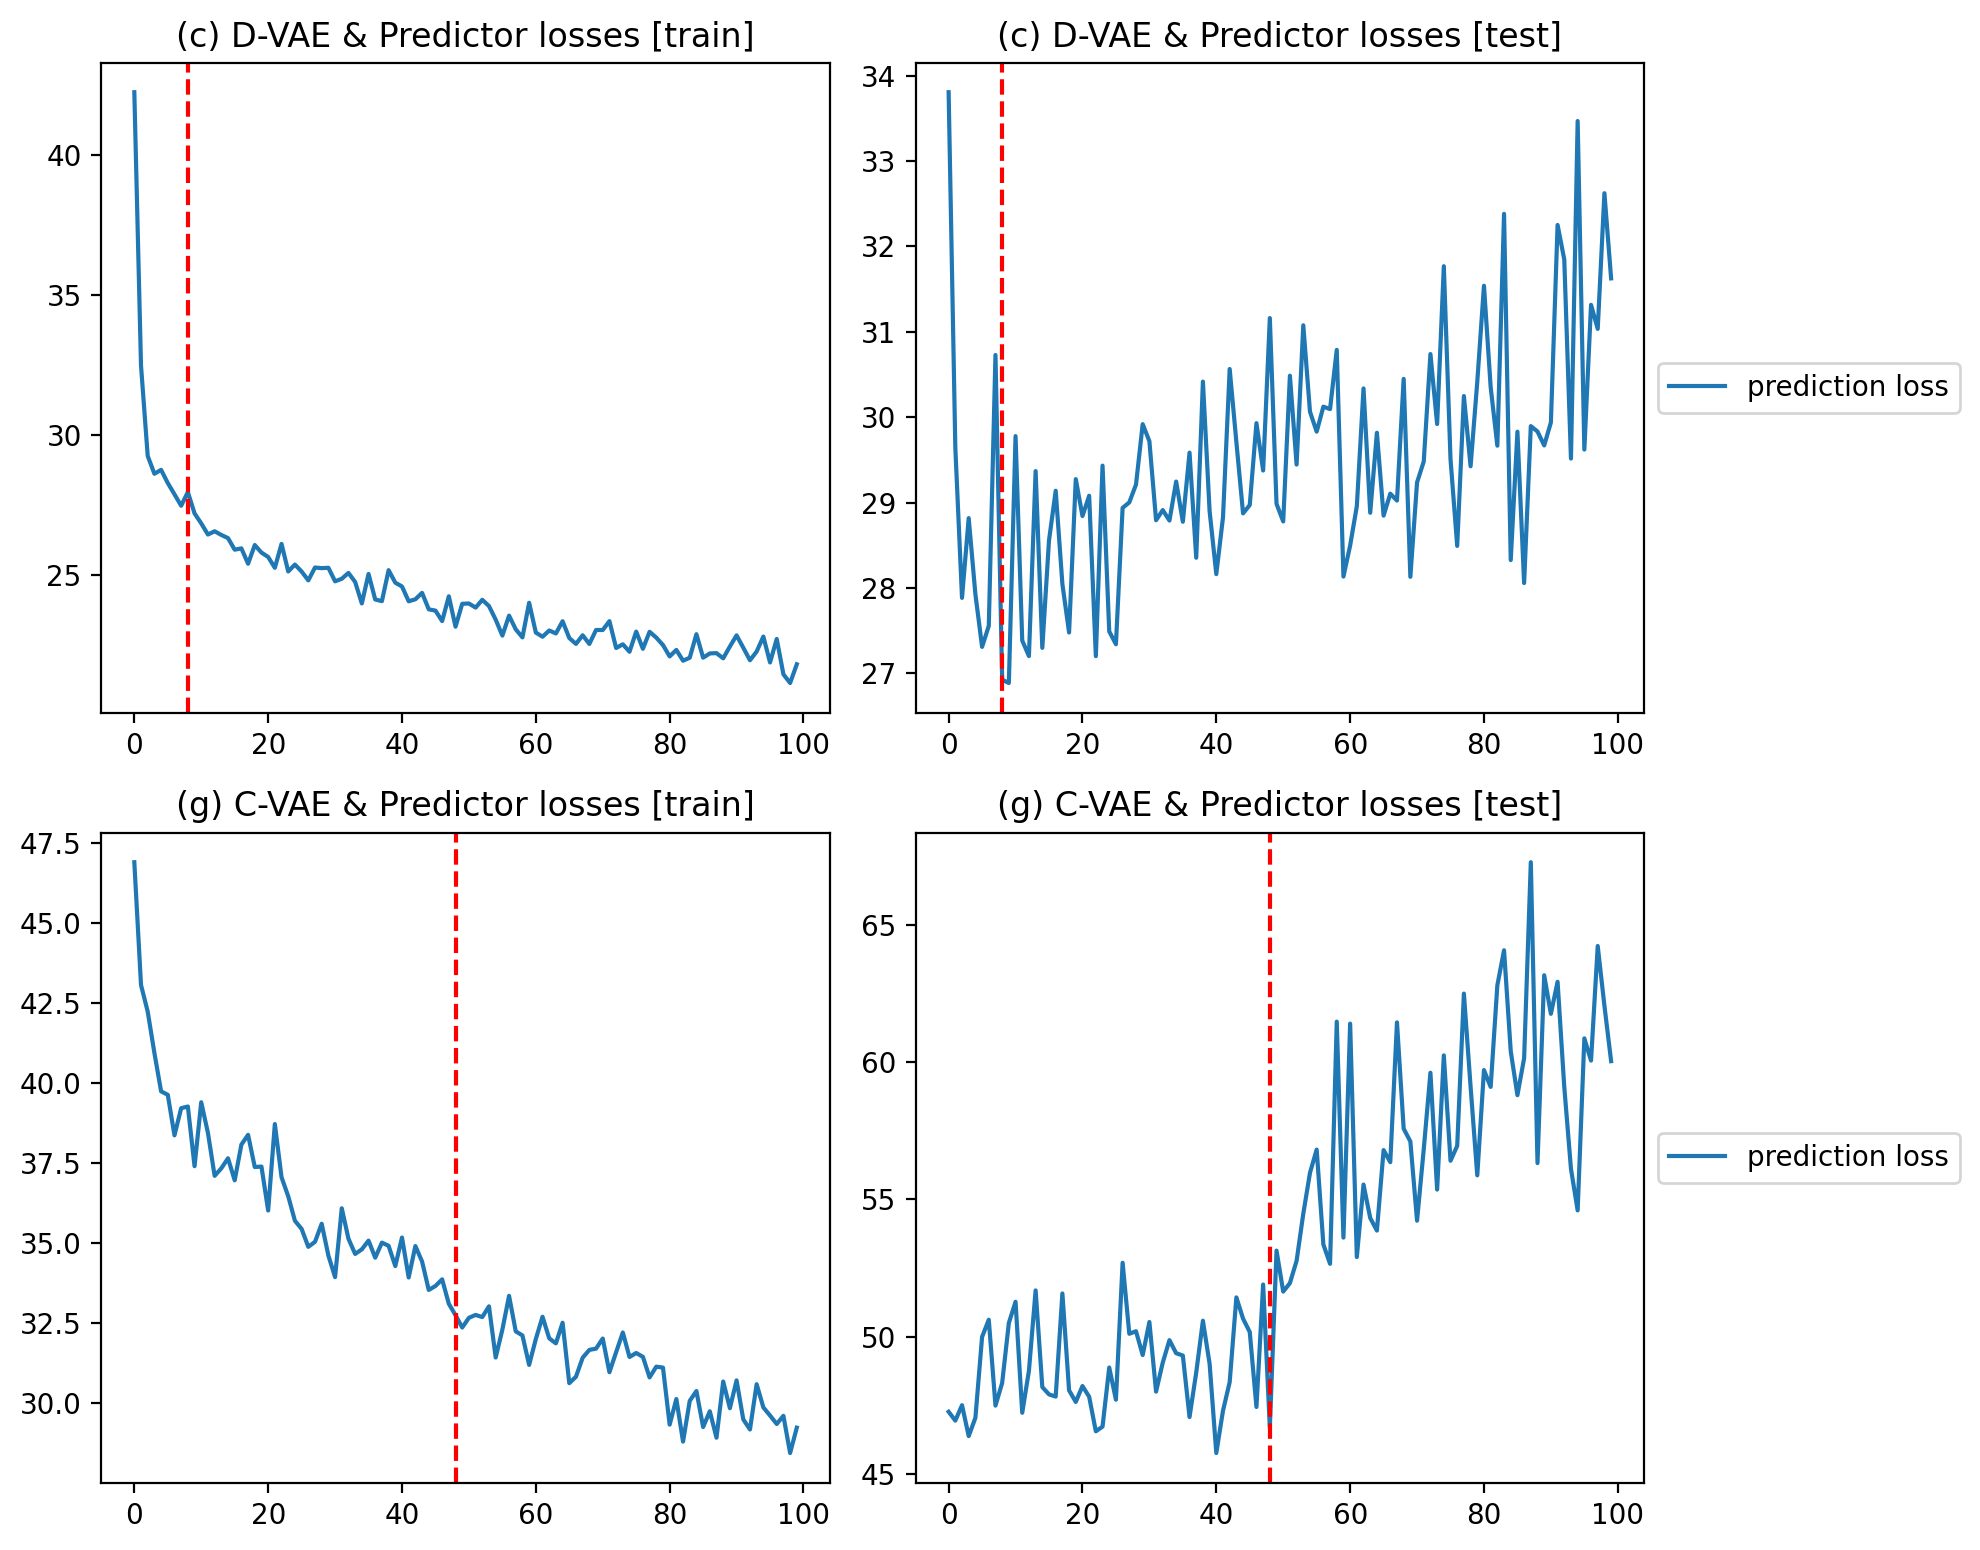

round 2:


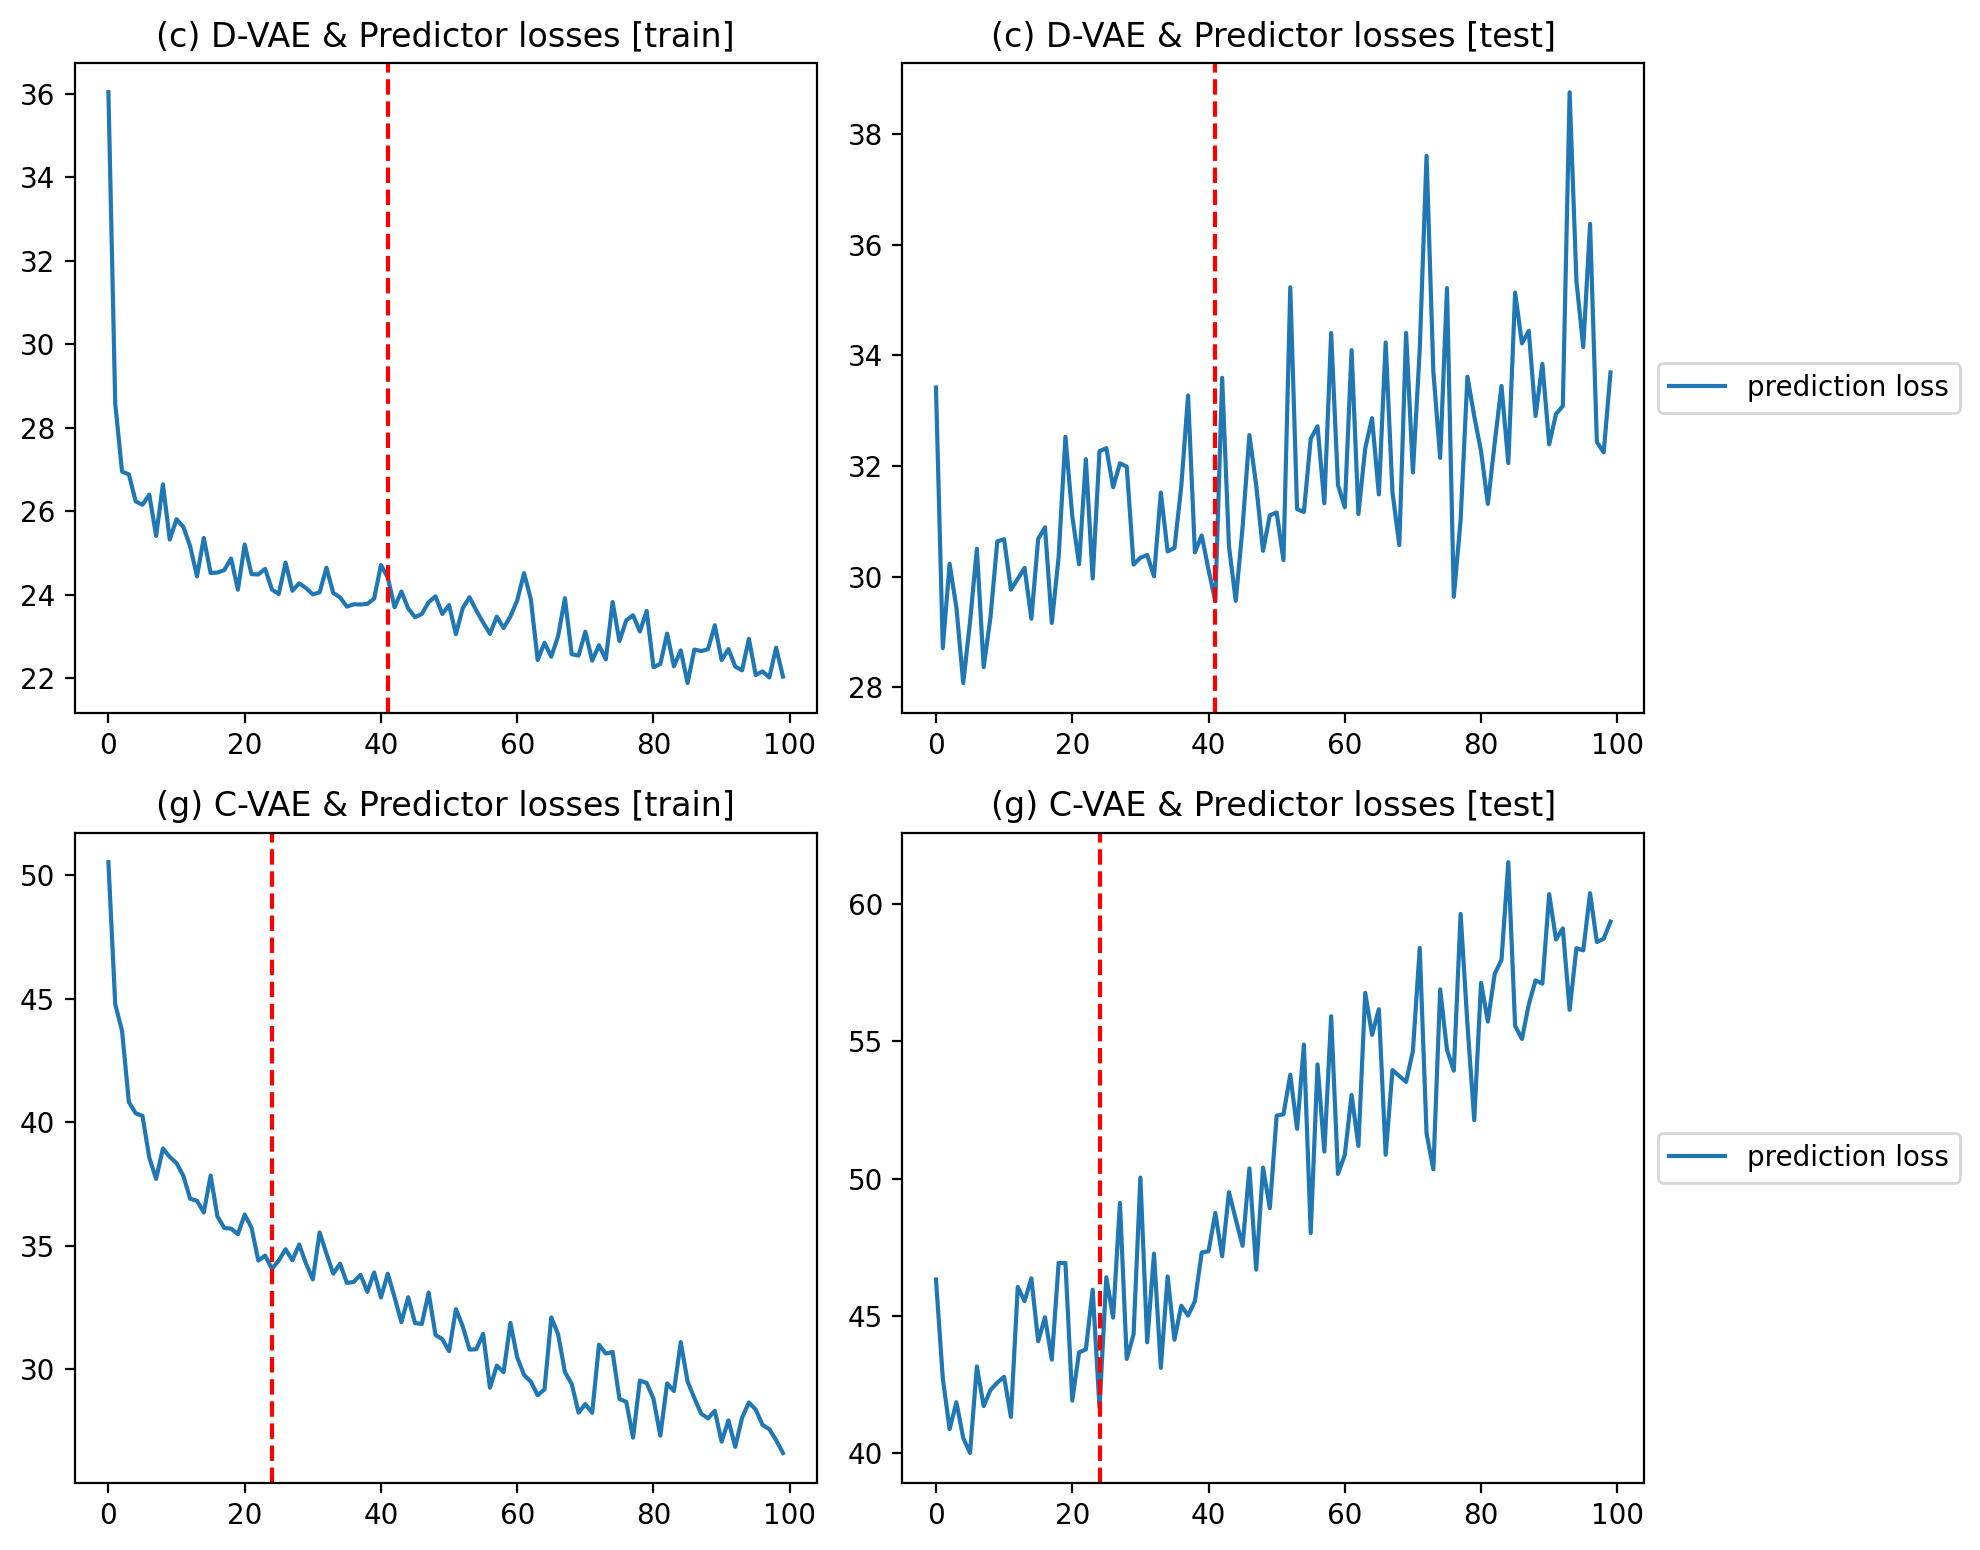

round 3:


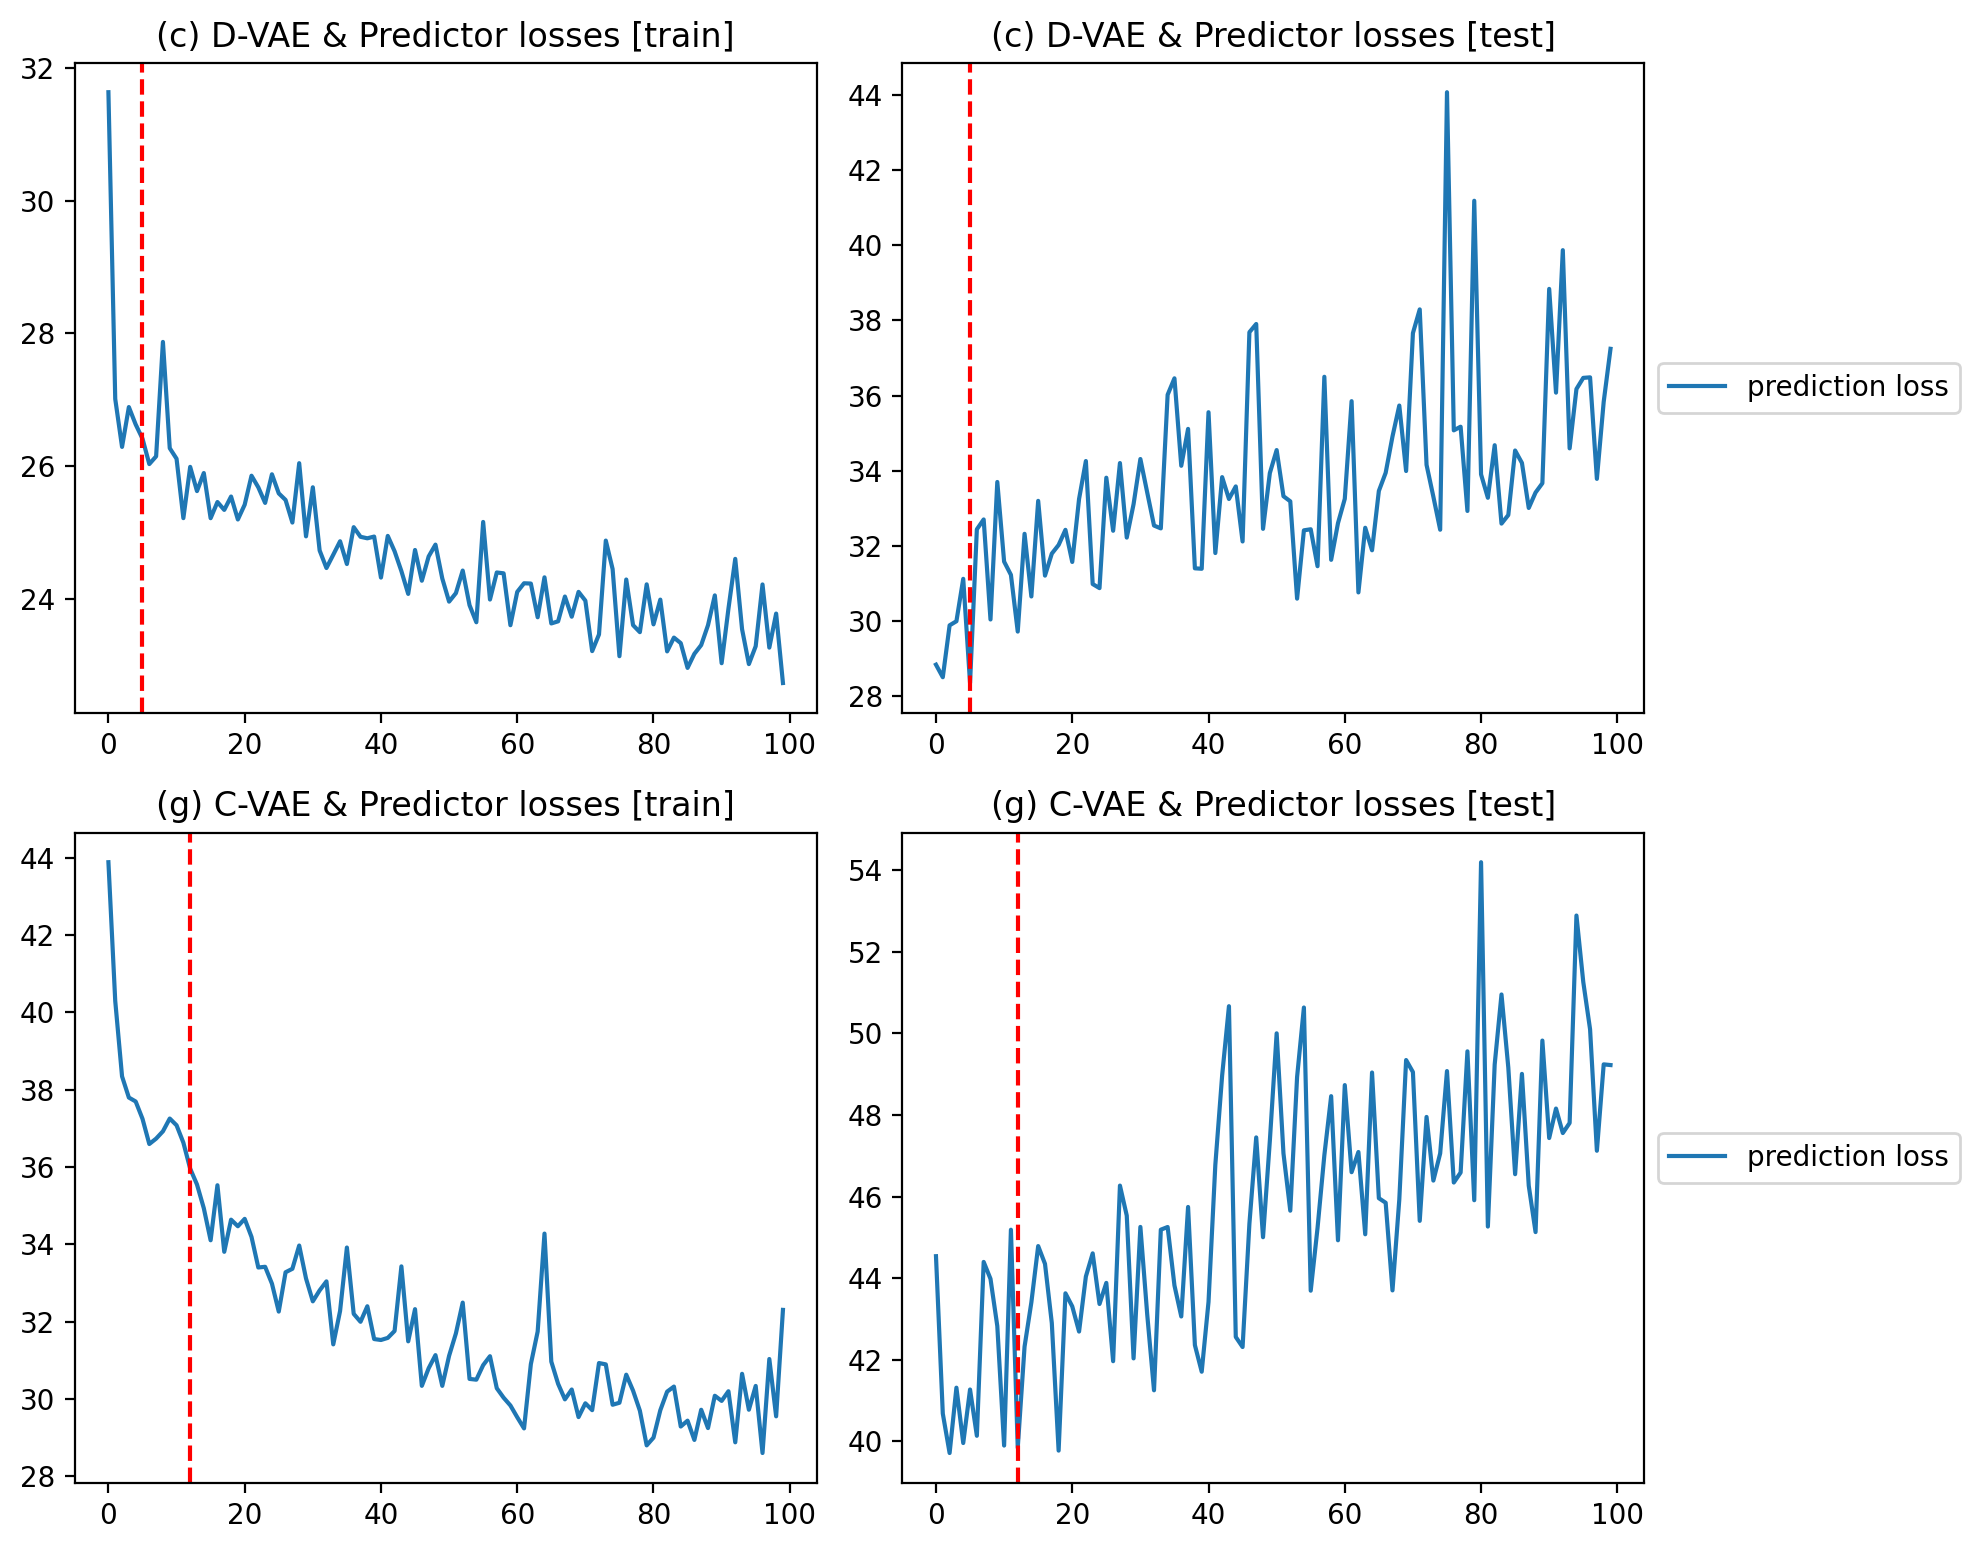

round 4:


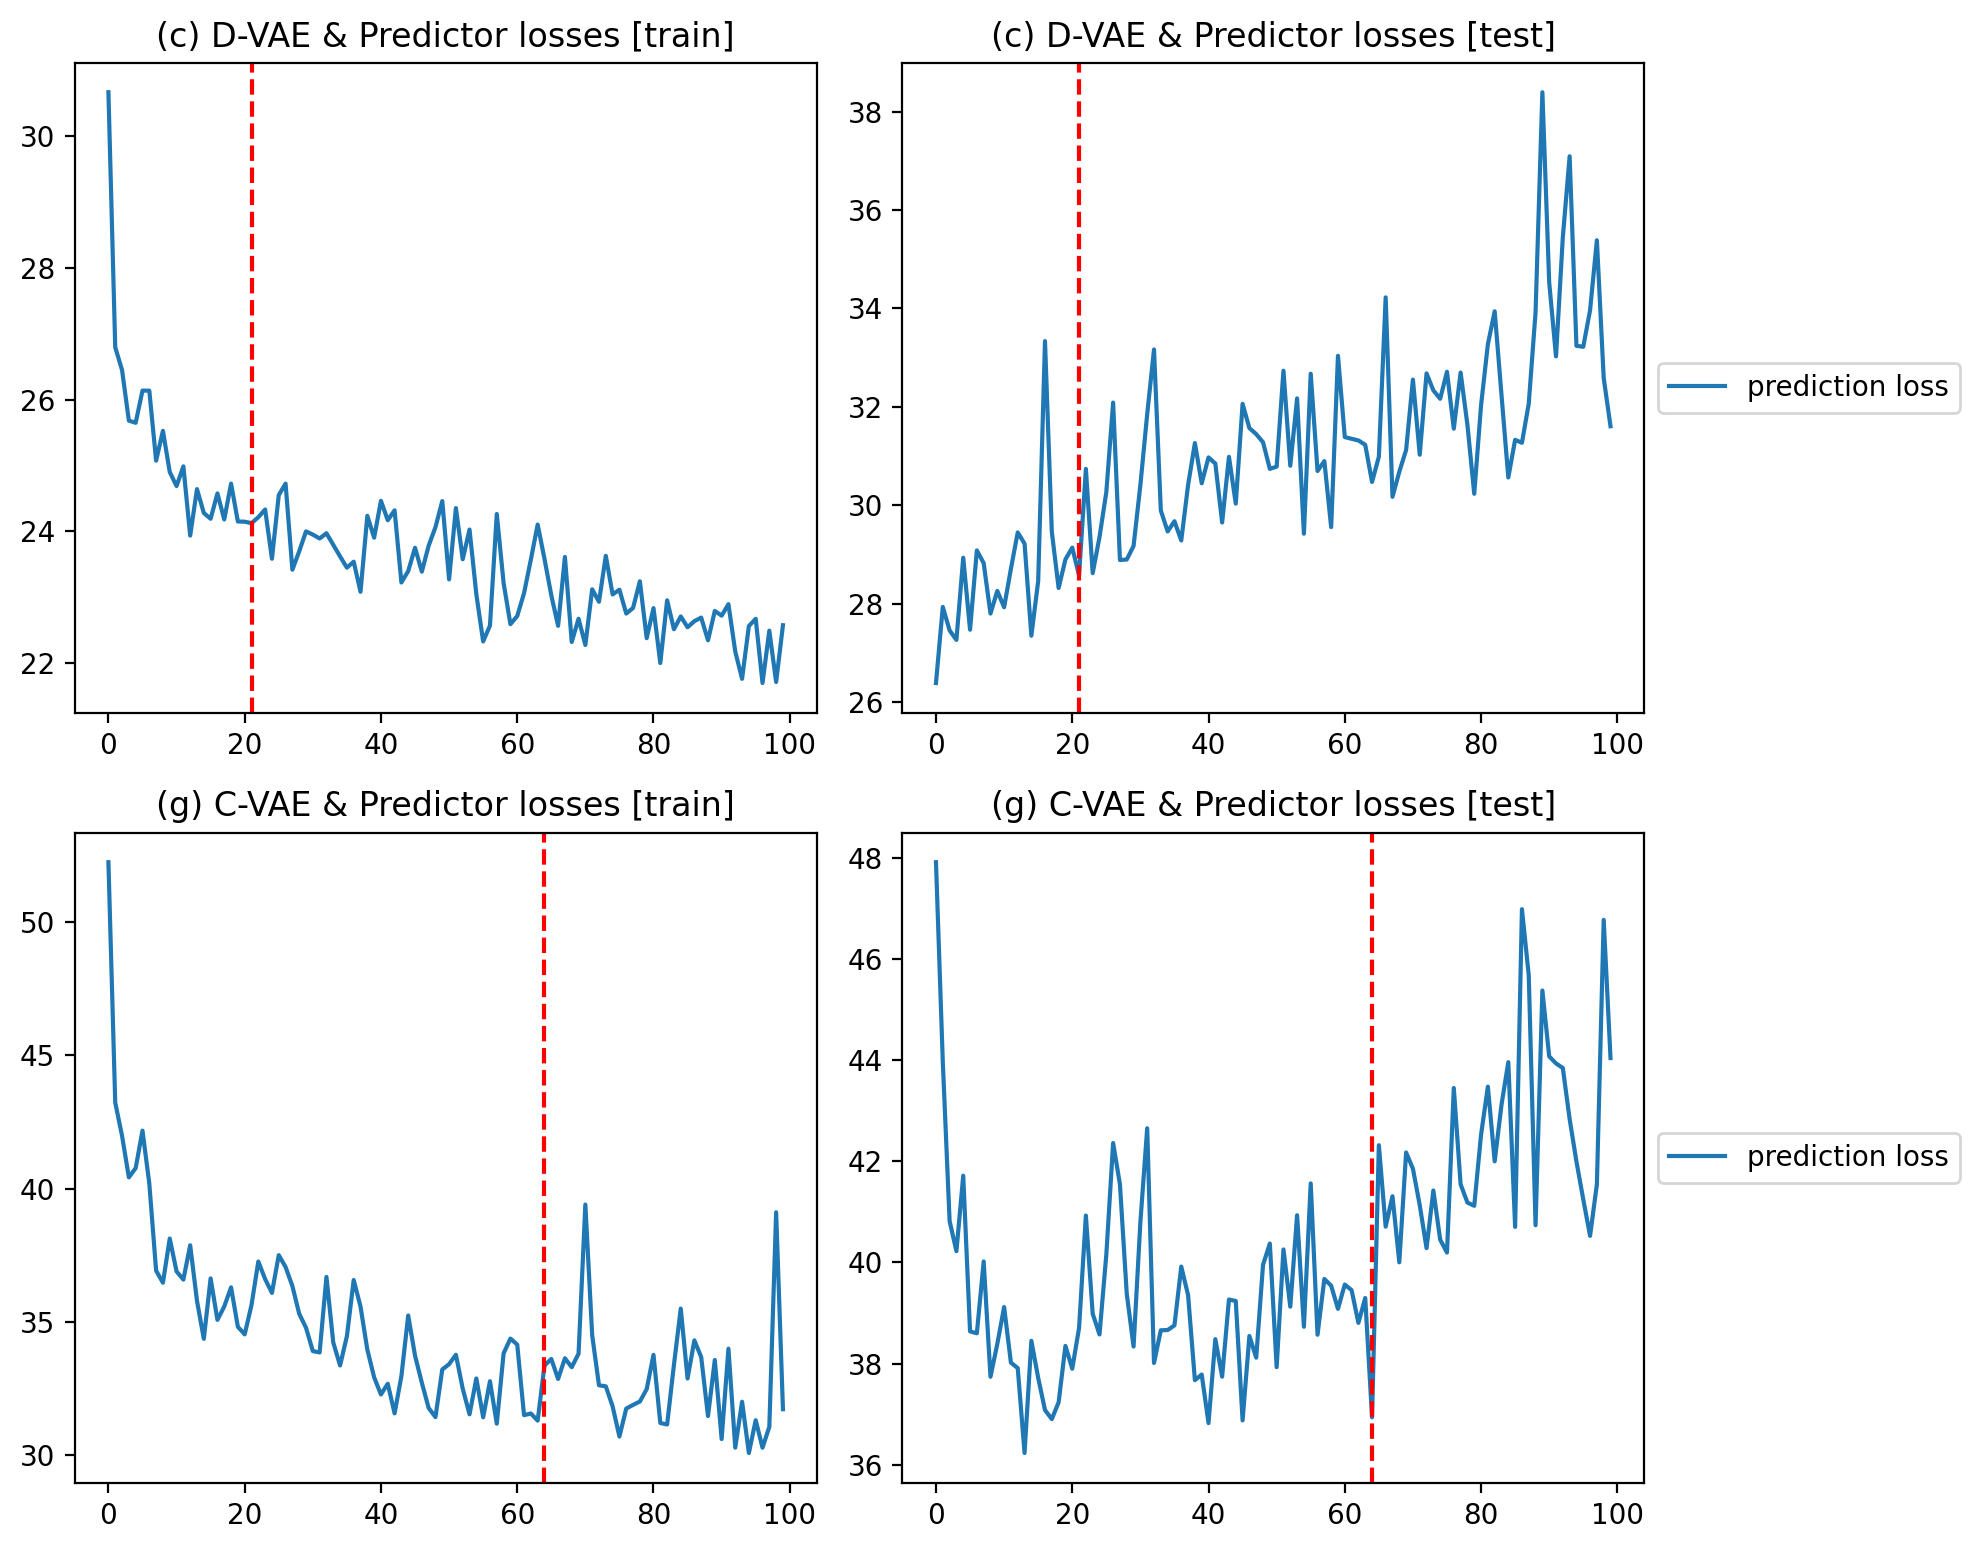

In [47]:
for k in range(CDPmodel.K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_pre_training_losses_train_test_2cols(losses_train_hist_list[k][b], best_epoch_1round = best_epos_list[k][b])
        

In [90]:
cdr_hat

c_name d_name   cdr_hat   cdr_all  cluster
0      753545   1830  0.123349  0.123349        0
1      753545   1997  0.000377  0.000377        0
2      753545   1046  0.211916  0.211916        0
3      753545   1089  0.001297  0.001297        0
4      753545   1268  0.003037  0.003037        0
...       ...    ...       ...       ...      ...
9391  1299080   1372  0.061808  0.061808        0
9392  1299080   1564  0.239475  0.239475        0
9393  1299080   1910  0.000603  0.000603        0
9394  1299080   1625  0.181554  0.181554        0
9395  1299080   1933  0.190372  0.190372        0

[9396 rows x 5 columns]

In [108]:
cdr_hat_wide = cdr_hat.pivot(index='c_name', columns='d_name', values='cdr_hat').astype(float).reset_index()
cdr_hat_wide.index = cdr_hat_wide['c_name']
cdr_hat_wide = cdr_hat_wide.drop('c_name', axis=1)

cdr_hat_wide

d_name       1003      1004      1006      1007      1008      1009      1010  \
c_name                                                                          
1240125  0.239475  0.305293  0.239475  0.287364  0.239475  0.209060  0.057562   
1240130  0.314612  0.427621  0.071040  0.370364  0.263028  0.002499  0.000321   
1240153  0.239475  0.290375  0.239475  0.243671  0.239475  0.032526  0.004291   
1240226  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1287706  0.239475  0.272683  0.205566  0.239475  0.239475  0.011036  0.001429   
1298144  0.252347  0.323615  0.239475  0.301926  0.239475  0.159052  0.023671   
1298145  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1298160  0.239475  0.239475  0.239475  0.239475  0.239475  0.046677  0.006237   
1299078  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1299080  0.295416  0.398919  0.239475  0.349501  0.265099  0.023253  0.003042   
1299081  0.396573  0.516823  0.239475  0.457161  0.361196  0.092641  0.018338   
687448   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
753545   0.293131  0.402960  0.205418  0.347003  0.262961  0.008398  0.001084   
753546   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
753579   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
753581   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
753596   0.239475  0.305303  0.239475  0.257068  0.239475  0.023288  0.003047   
905954   0.239475  0.239475  0.239475  0.239475  0.239475  0.200256  0.033217   
905955   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
905956   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
905974   0.486792  0.606885  0.239475  0.548631  0.449360  0.127988  0.032803   
905975   0.370434  0.400243  0.239475  0.387351  0.347080  0.021557  0.002816   
905976   0.239475  0.303838  0.239475  0.257905  0.239475  0.034763  0.004596   
905977   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
906792   0.192182  0.426341  0.053173  0.369144  0.104022  0.017522  0.004104   
906793   0.536382  0.653138  0.113515  0.597190  0.401455  0.039076  0.009309   
906813   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
906814   0.239475  0.311242  0.174293  0.262424  0.239475  0.062822  0.015253   
906818   0.239475  0.239475  0.239475  0.239475  0.239475  0.139405  0.022385   
906830   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
906865   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
907058   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
907067   0.239475  0.257796  0.239475  0.239475  0.239475  0.172384  0.026006   
907169   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
907171   0.332922  0.448207  0.239475  0.390071  0.300396  0.170486  0.045338   
907172   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
908124   0.239475  0.239475  0.239475  0.239475  0.239475  0.112836  0.016430   
908125   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
908128   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
909706   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
909713   0.239475  0.227779  0.239475  0.239475  0.239475  0.096371  0.013487   
909723   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
909724   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
909725   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
909726   0.239475  0.239475  0.239475  0.239475  0.239475  0.226366  0.039600   
909727   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
909784   0.239475  0.327311  0.209195  0.276985  0.239475  0.016736  0.002177   
910853   0.000000  0.000000  0.

# Heatmap

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [75]:
np.any(np.isinf(cdr_array))

False

In [86]:
cdr.shape

(54, 174)

<AxesSubplot:>

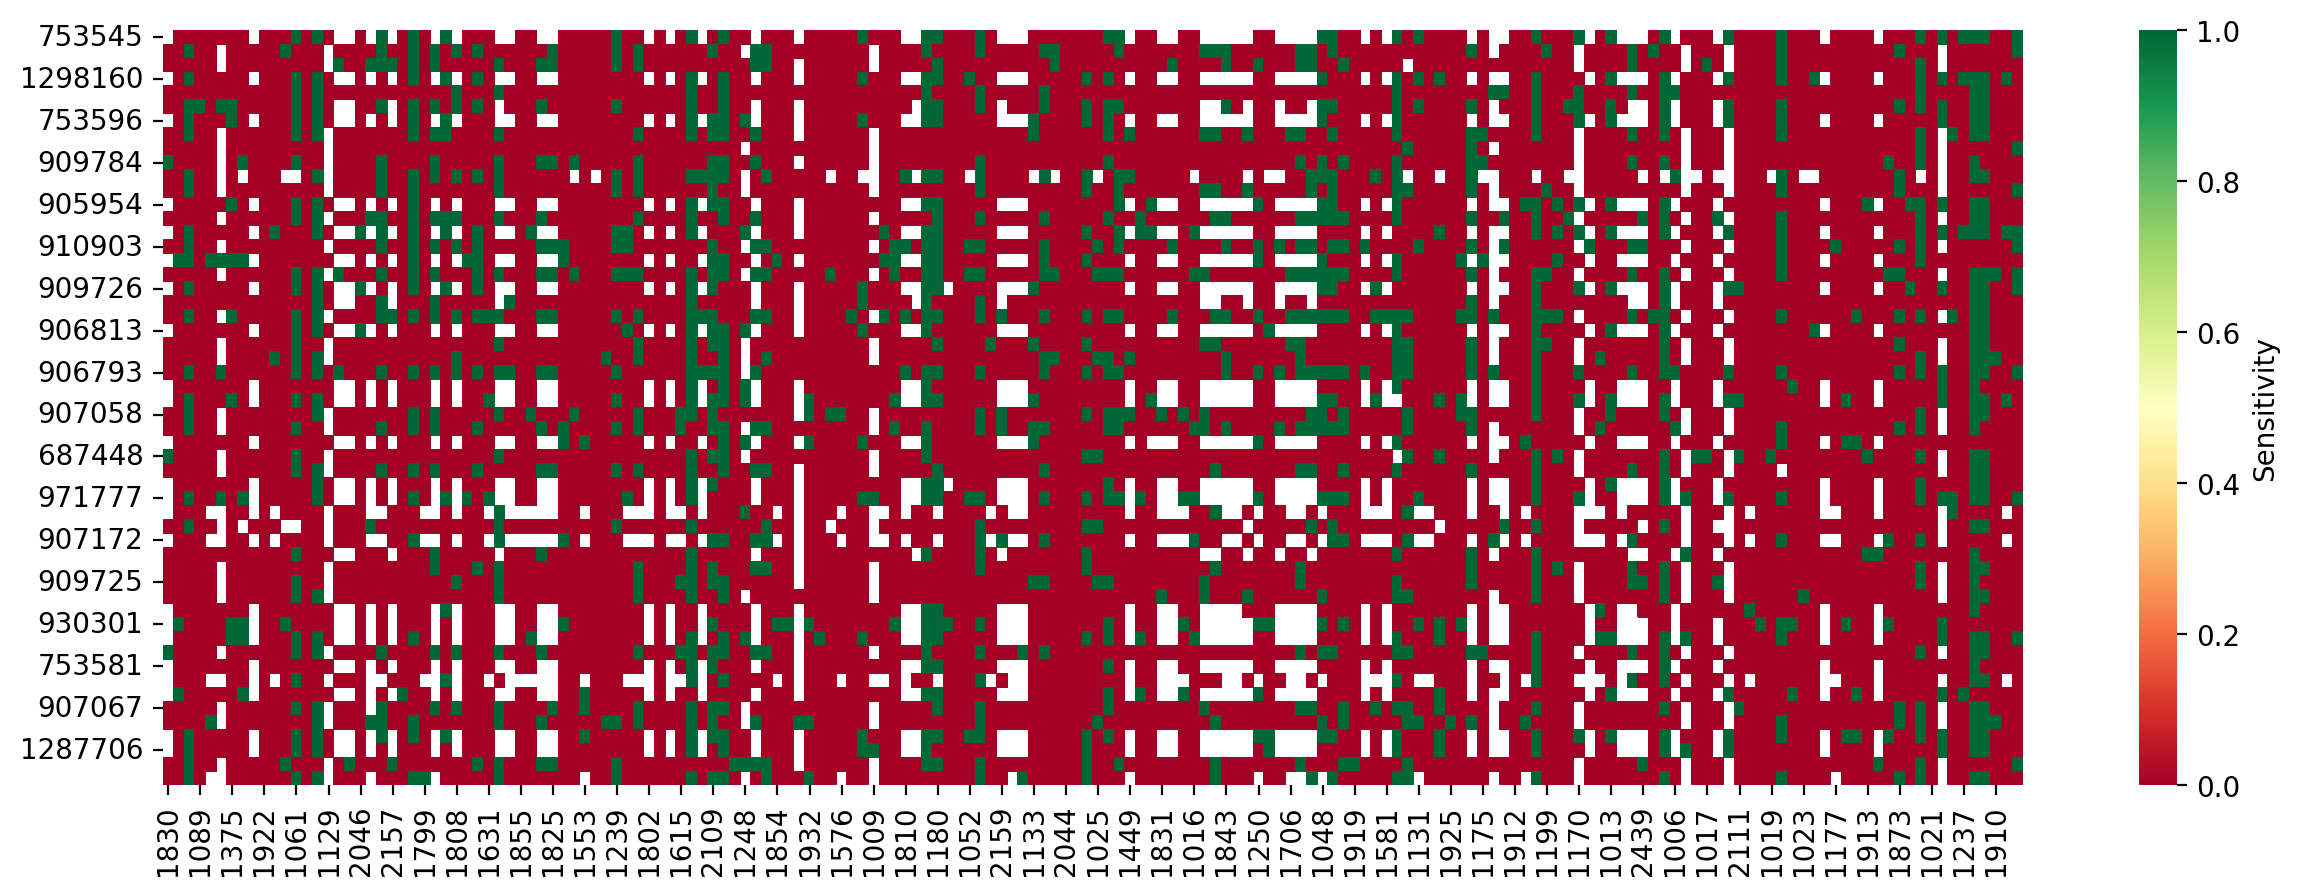

In [98]:

fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(cdr, 
            cmap="RdYlGn",
            cbar_kws={'label': 'Sensitivity'})

<AxesSubplot:xlabel='d_name', ylabel='c_name'>

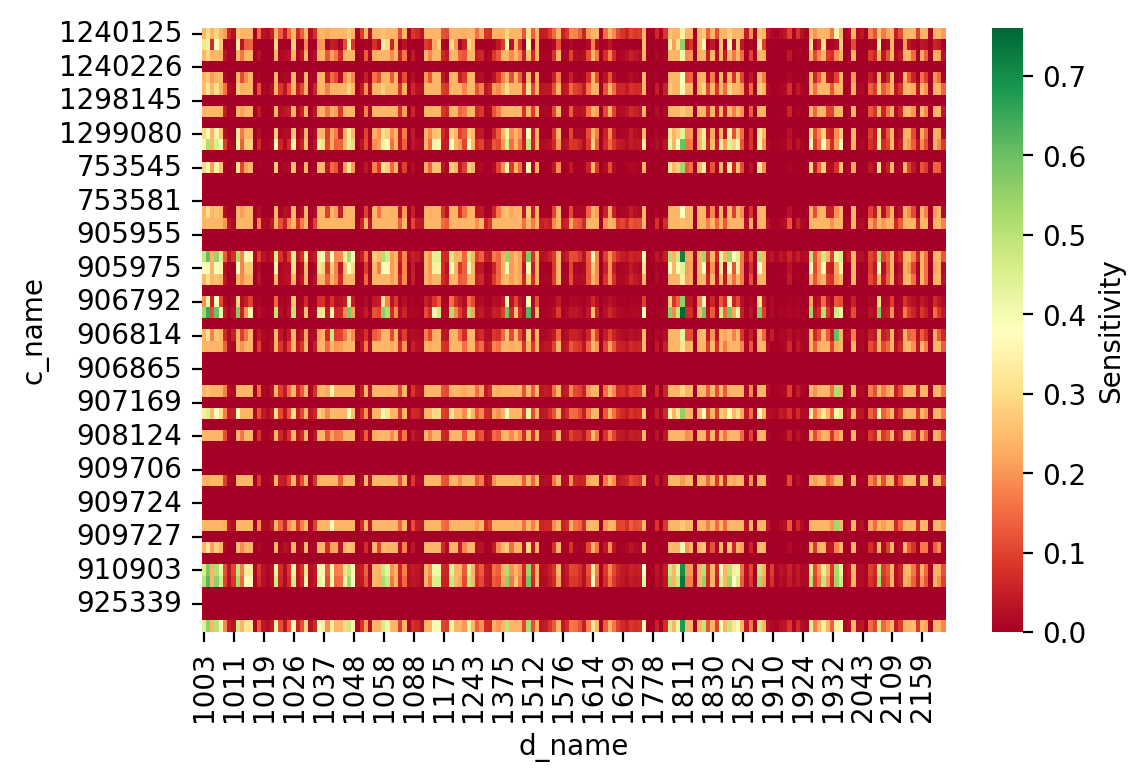

In [109]:
# Convert non-numeric values to NaN

sns.heatmap(cdr_hat_wide, 
            cmap="RdYlGn",
            cbar_kws={'label': 'Sensitivity'})

<ipython-input-140-19a86bf6f0e7>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])


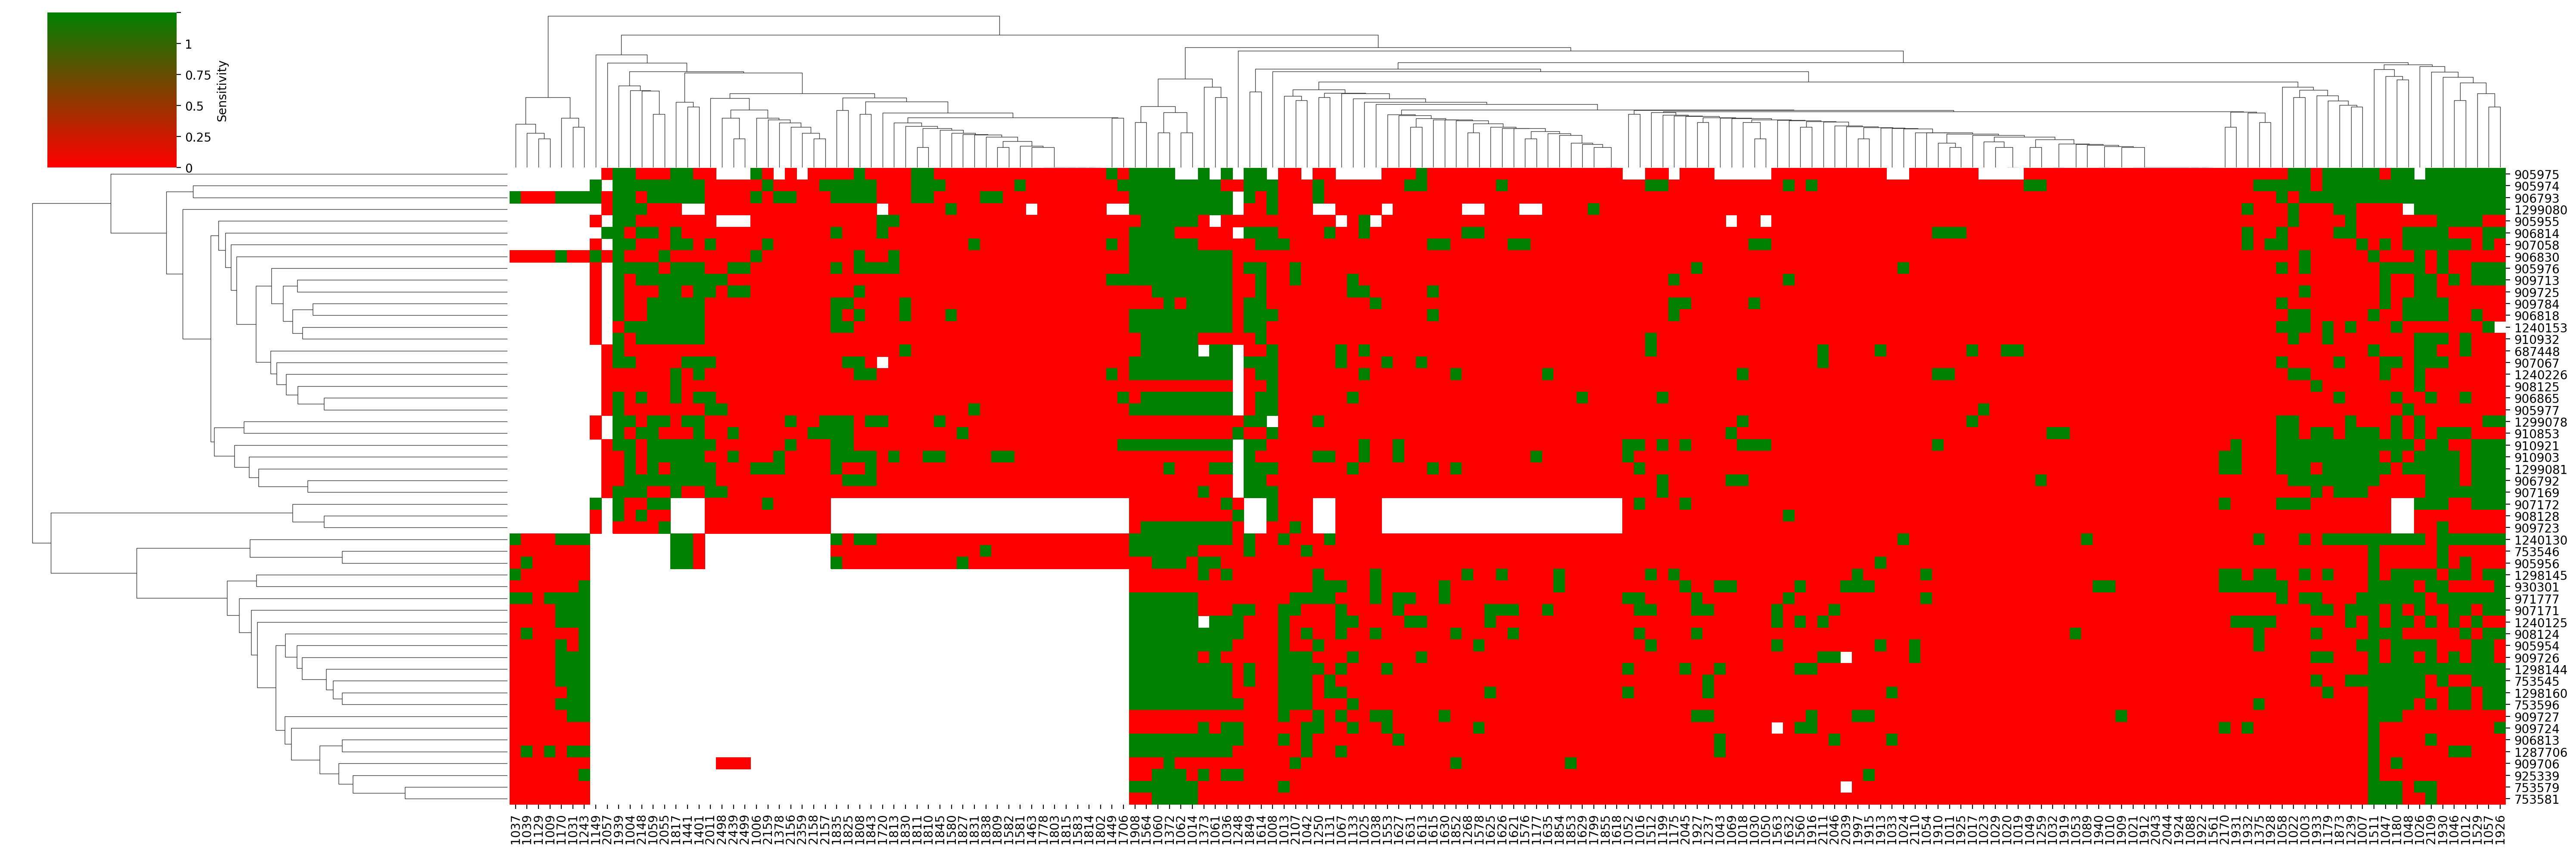

In [140]:
cdr_array = np.array(cdr)

# Create a mask for missing values
mask = np.isnan(cdr_array)

# Replace missing values with a placeholder (e.g., -1)
cdr_array_with_placeholder = np.where(mask, -1, cdr_array)

# Create a custom color map
cmap = LinearSegmentedColormap.from_list(
    "custom_colormap",
    [(0, "red"), (1, "green")],
    N=256,
)
cmap.set_under("grey")

# Calculate linkage matrices based on non-missing values
row_linkage = linkage(cdr_array_with_placeholder, method='ward', metric='euclidean')
col_linkage = linkage(cdr_array_with_placeholder.T, method='ward', metric='euclidean')

# cancer names and drug names
column_names = cdr.columns.tolist()
row_names = cdr.index.tolist()

# Create a custom color map
cmap = LinearSegmentedColormap.from_list(
    "custom_colormap",
    [(0, "red"), (1, "green")],
    N=256,
)
cmap.set_under("grey")

# Create the clustermap with the specified color map
sns.clustermap(
    data=cdr_array_with_placeholder,
    row_cluster=True,
    col_cluster=True,
    mask = mask,
    cmap=cmap,
    center=0.5,  # Center the color map at 1 (midpoint)
    vmin=0,  # Minimum value for the colormap (0)
    vmax=1,  # Maximum value for the colormap (1)
    dendrogram_ratio=(0.2, 0.2),
    cbar_kws={"label": "Sensitivity"},
    figsize=(30, 10),
    xticklabels=column_names,  # Set column names as x-axis labels
    yticklabels=row_names,    # Set row names as y-axis labels
)

# Optionally, set the colorbar labels
cbar = plt.gcf().axes[-1]
cbar.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])

plt.show()

<ipython-input-116-f2baa1f28d1f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_yticklabels(['Low', 'High', 'Missing'])


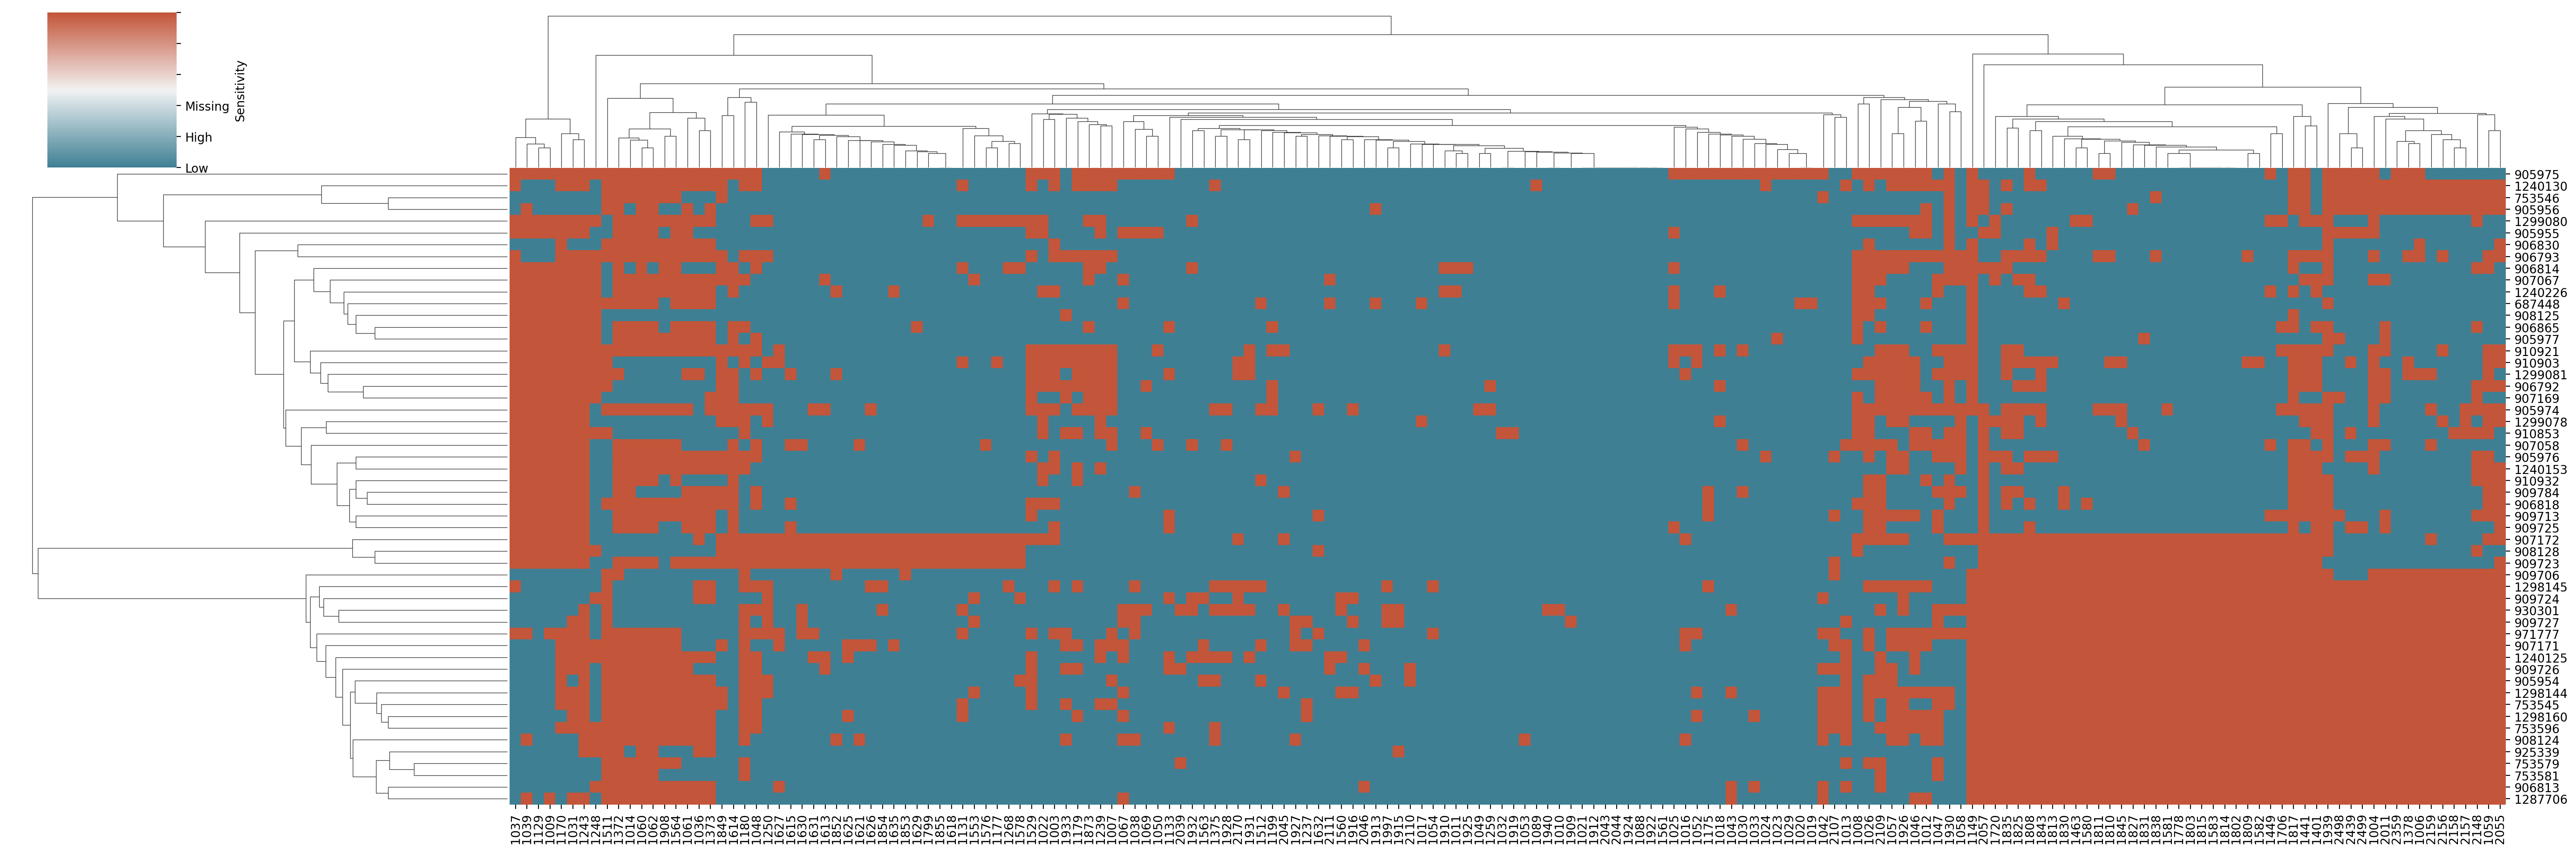

In [116]:
cdr_array = np.array(cdr)
cdr_array[np.isnan(cdr)] = 2  # Replace NaN with a value outside [0, 1]

column_names = cdr.columns.tolist()
row_names = cdr.index.tolist()

# Create a custom color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create the clustermap with the specified color map
sns.clustermap(
    data=cdr_array,
    row_cluster=True,
    col_cluster=True,
    cmap=cmap,
    center=0.5,  # Center the color map at 1 (midpoint)
    vmin=0,  # Minimum value for the colormap (0)
    vmax=1,  # Maximum value for the colormap (1)
    dendrogram_ratio=(0.2, 0.2),
    cbar_kws={"label": "Sensitivity"},
    figsize=(30, 10),
    xticklabels=column_names,  # Set column names as x-axis labels
    yticklabels=row_names,    # Set row names as y-axis labels
)

# Optionally, set the colorbar labels
cbar = plt.gcf().axes[-1]
cbar.set_yticklabels(['Low', 'High', 'Missing'])

plt.show()

<ipython-input-110-d30c6a5ea70a>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_yticklabels(['Low', 'High', 'Missing'])


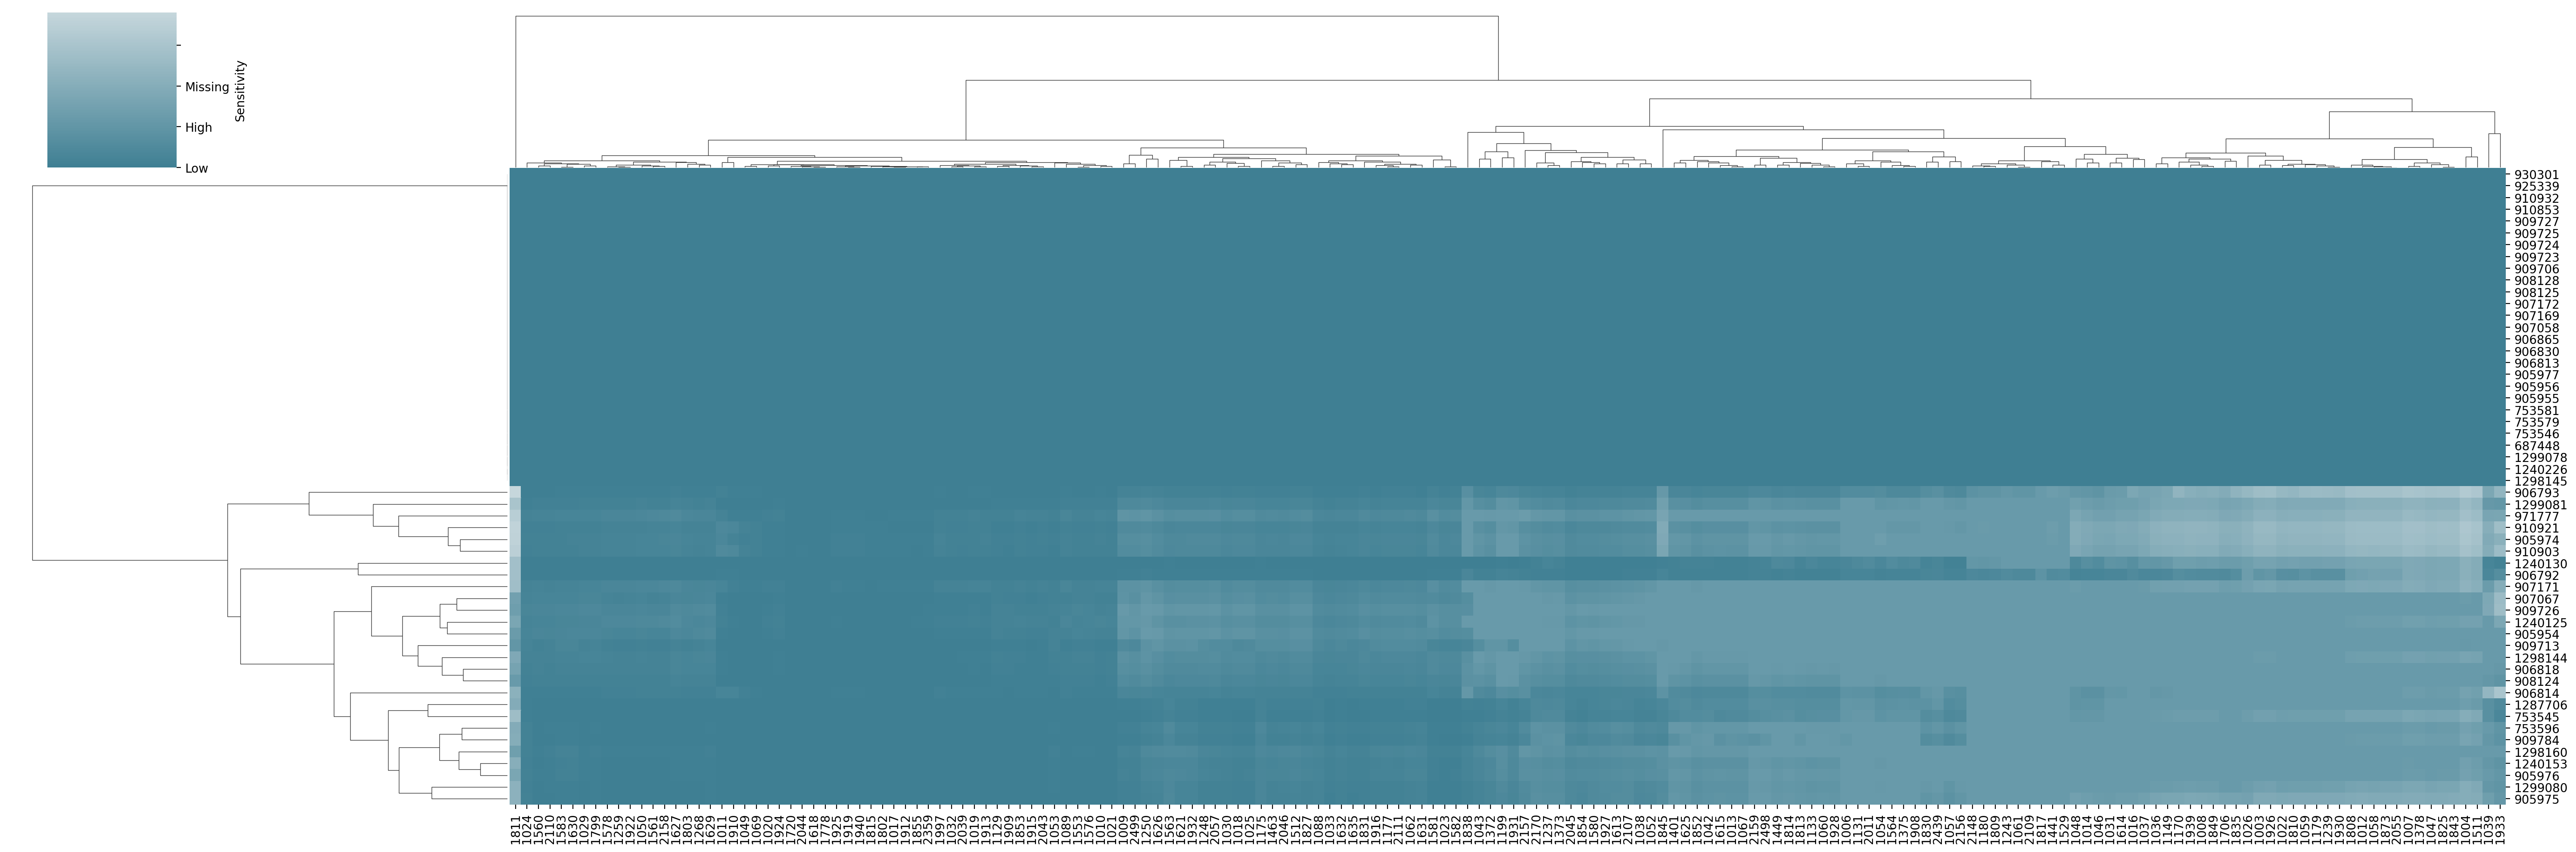

In [110]:
cdr_array = np.array(cdr_hat_wide)
cdr_array[np.isnan(cdr_hat_wide)] = 2  # Replace NaN with a value outside [0, 1]

column_names = cdr_hat_wide.columns.tolist()
row_names = cdr_hat_wide.index.tolist()

# Create a custom color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create the clustermap with the specified color map
sns.clustermap(
    data=cdr_array,
    row_cluster=True,
    col_cluster=True,
    cmap=cmap,
    center=1,  # Center the color map at 1 (midpoint)
    dendrogram_ratio=(0.2, 0.2),
    cbar_kws={"label": "Sensitivity"},
    figsize=(30, 10),
    xticklabels=column_names,  # Set column names as x-axis labels
    yticklabels=row_names,    # Set row names as y-axis labels
)

# Optionally, set the colorbar labels
cbar = plt.gcf().axes[-1]
cbar.set_yticklabels(['Low', 'High', 'Missing'])

plt.show()

<ipython-input-77-a8e7b996f0e2>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_yticklabels(['0', 'Missing', '1'])


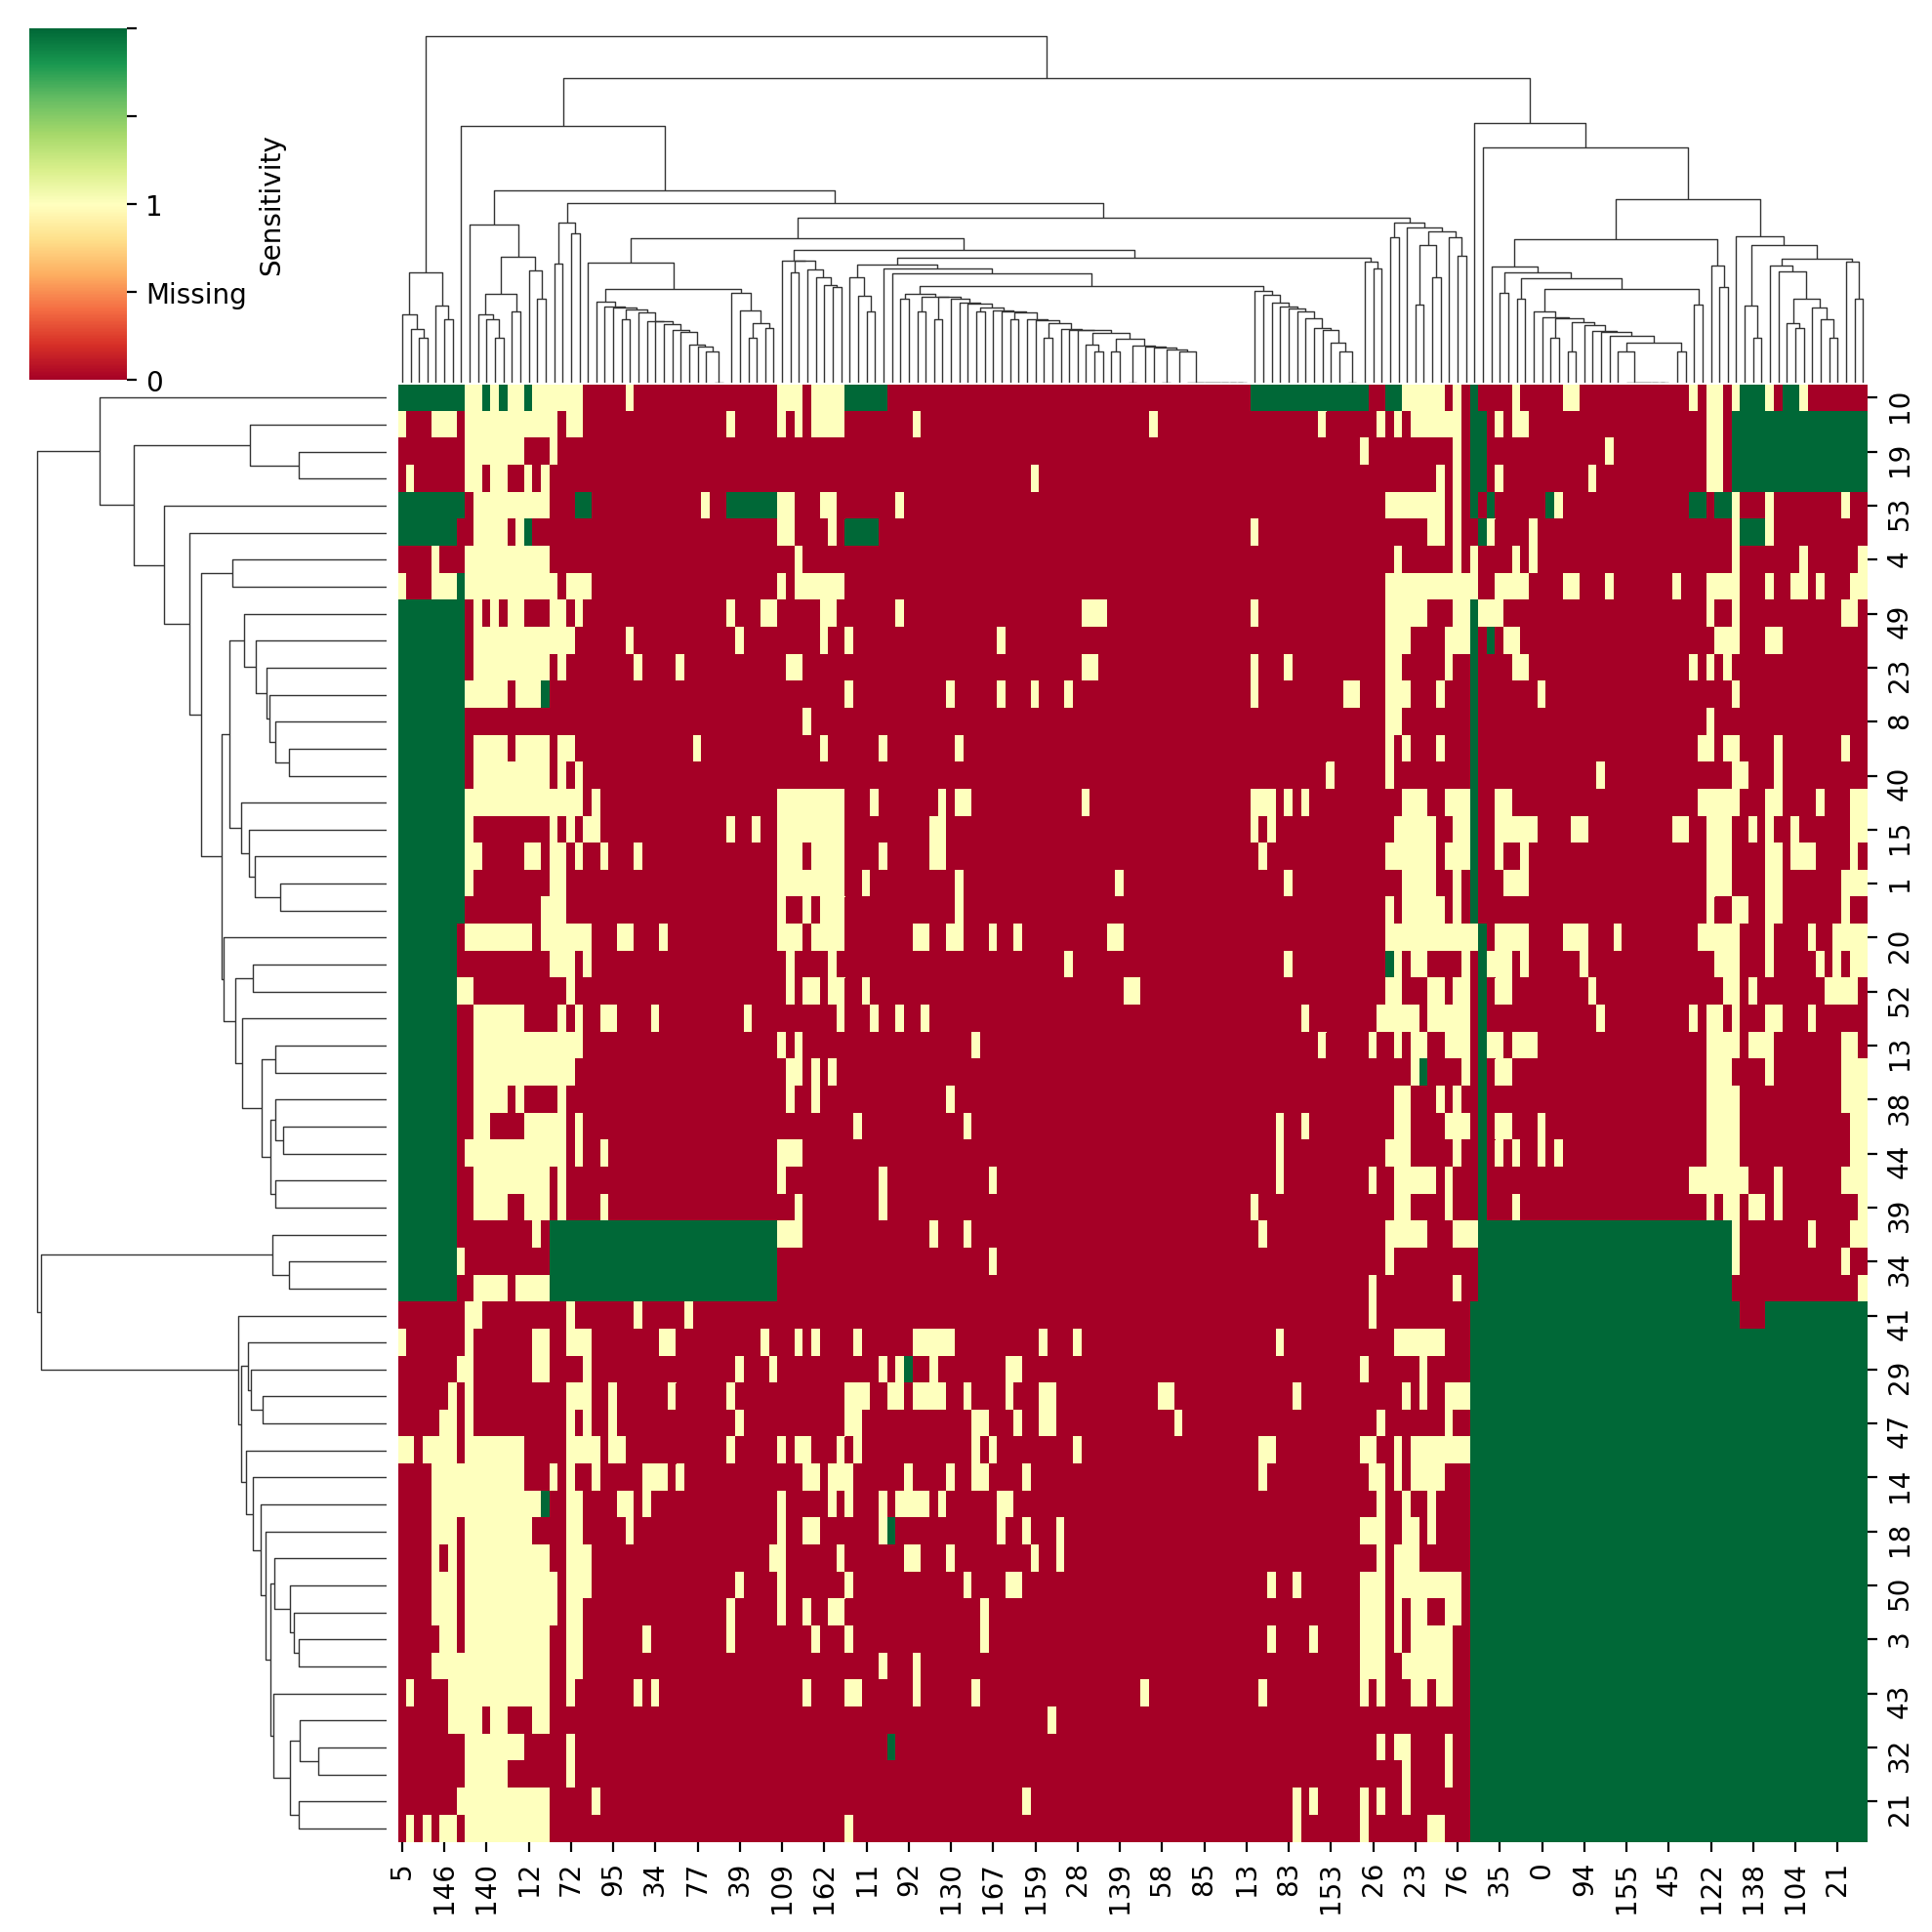

In [77]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Replace NaN values in cdr_array with 2 (or any value outside the range [0, 1])
cdr_array = np.array(cdr)
cdr_array[np.isnan(cdr)] = 2  # Replace NaN with a value outside [0, 1]

# Create a custom color map that transitions from red to green
cmap = sns.color_palette("RdYlGn", as_cmap=True)

# Create the clustermap with the specified color map
sns.clustermap(
    data=cdr_array,
    row_cluster=True,
    col_cluster=True,
    cmap=cmap,
    center=1,  # Center the color map at 1 (midpoint)
    dendrogram_ratio=(0.2, 0.2),
    cbar_kws={"label": "Sensitivity"},
    figsize=(10, 10),
)

# Optionally, set the colorbar labels
cbar = plt.gcf().axes[-1]
cbar.set_yticklabels(['0', 'Missing', '1'])

plt.show()

<ipython-input-111-b28b74953ac4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_yticklabels(['Low', 'High', 'Missing'])


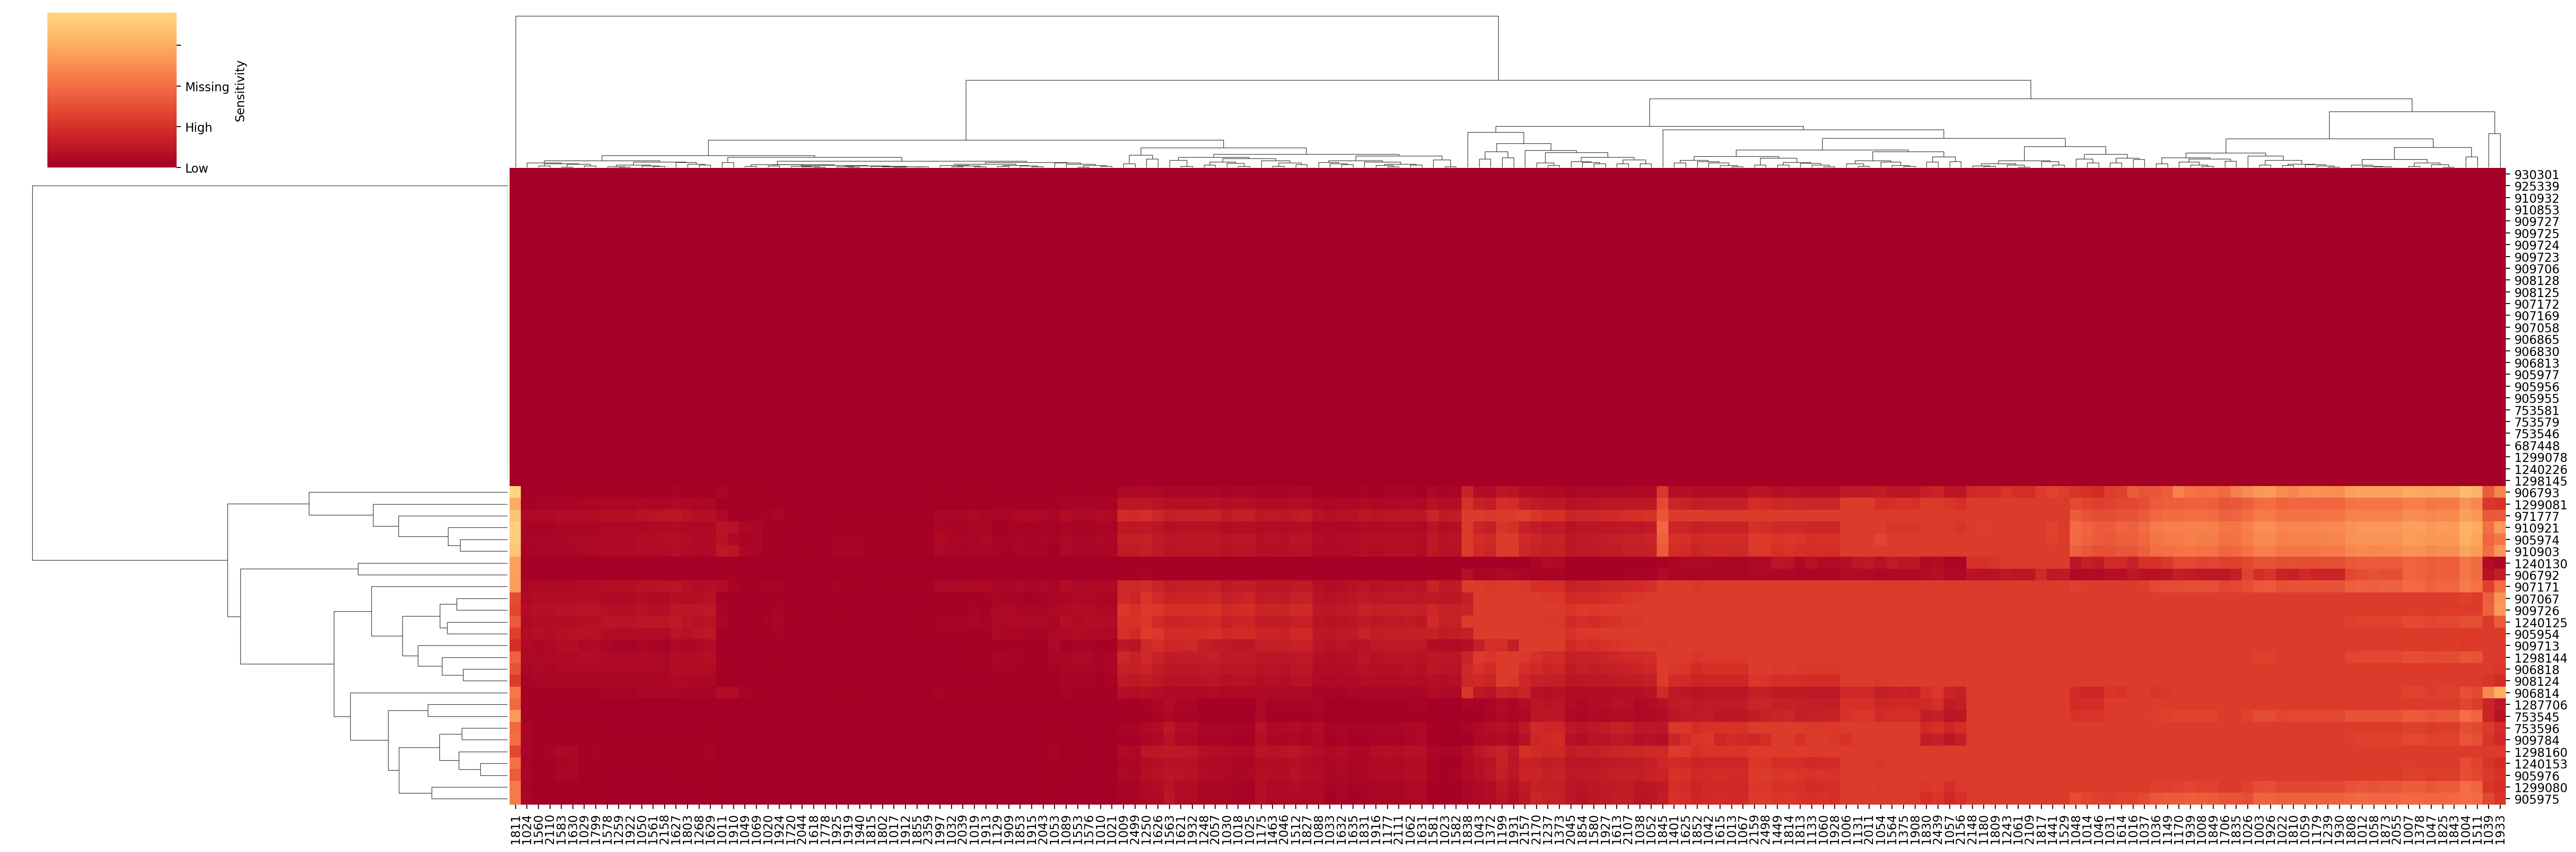

In [111]:
cdr_array = np.array(cdr_hat_wide)
cdr_array[np.isnan(cdr_hat_wide)] = 2  # Replace NaN with a value outside [0, 1]

column_names = cdr_hat_wide.columns.tolist()
row_names = cdr_hat_wide.index.tolist()

# Create a custom color map
cmap = sns.color_palette("RdYlGn", as_cmap=True)

# Create the clustermap with the specified color map
sns.clustermap(
    data=cdr_array,
    row_cluster=True,
    col_cluster=True,
    cmap=cmap,
    center=1,  # Center the color map at 1 (midpoint)
    dendrogram_ratio=(0.2, 0.2),
    cbar_kws={"label": "Sensitivity"},
    figsize=(30, 10),
    xticklabels=column_names,  # Set column names as x-axis labels
    yticklabels=row_names,    # Set row names as y-axis labels
)

# Optionally, set the colorbar labels
cbar = plt.gcf().axes[-1]
cbar.set_yticklabels(['Low', 'High', 'Missing'])

plt.show()

### 